In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, transforms, datasets, models
import torchvision.transforms as transforms
!pip install ultralytics
from ultralytics import YOLO
from PIL import Image
from sklearn.metrics import confusion_matrix
import csv
!pip install timm
import timm

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/61/07/64a75bf94a4325f1c8f249a55caee74111c68441c912bf1d3ef0c1a2bc7b/ultralytics-8.2.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 788.7 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for thop>=0.1.1 from https://files.pythonhosted.org/packages/bb/0f/72beeab4ff5221dc47127c80f8834b4bcd0cb36f6ba91c0b1d04a1233403/thop-0.1.1.post2209072238-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 6.1 MB/s eta 0:00:00a 0:00:01


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


***CONSTANTS***

In [4]:
train_dir = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
num_classes = 65
image_shape = (224, 224)

***PREPROCESSING***

In [5]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
dataset = MakeDataset(train_dir, transform=transform)

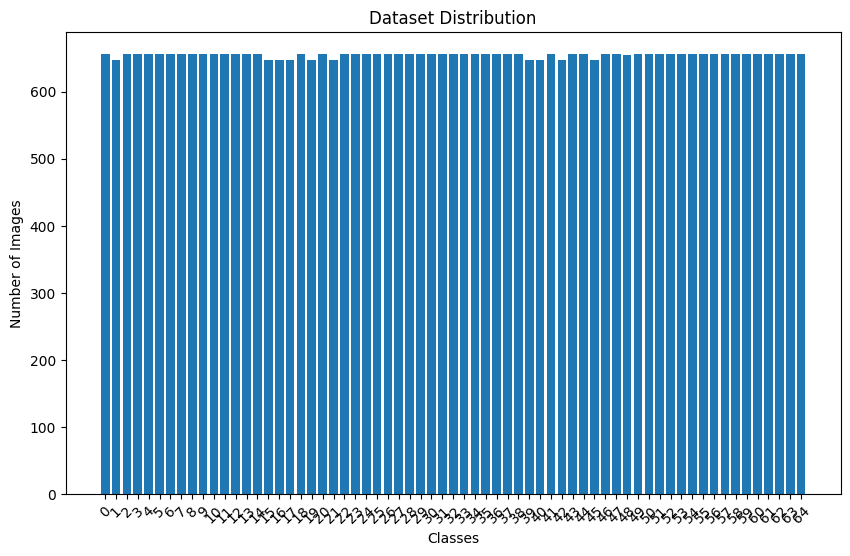

Minimum three letters based on the number of images:
1 648
15 648
16 648
17 648
19 648
21 648
39 648
40 648
42 648
45 648
48 655
0 656
2 656
3 656
4 656
5 656
6 656
7 656
8 656
9 656
10 656
11 656
12 656
13 656
14 656
18 656
20 656
22 656
23 656
24 656
25 656
26 656
27 656
28 656
29 656
30 656
31 656
32 656
33 656
34 656
35 656
36 656
37 656
38 656
41 656
43 656
44 656
46 656
47 656
49 656
50 656
51 656
52 656
53 656
54 656
55 656
56 656
57 656
58 656
59 656
60 656
61 656
62 656
63 656
64 656


In [8]:
class_counts = {cls: 0 for cls in dataset.classes}
for _, label in dataset.images:
    class_counts[dataset.classes[label]] += 1

# Plot the dataset distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(rotation=45)
plt.show()

# Find the minimum three letters based on the number of images
min_three_letters = sorted(dataset.class_to_idx, key=lambda x: class_counts[x])

print("Minimum three letters based on the number of images:")
for letter in min_three_letters:
    print(letter, class_counts[letter])

In [9]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [10]:
batch_size = 8

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

***VISUALIZATION***

In [13]:
def show_images(images, labels, ncols=8):
    figure, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f'Class: {labels[i]}')
        ax.axis('off')

In [14]:
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

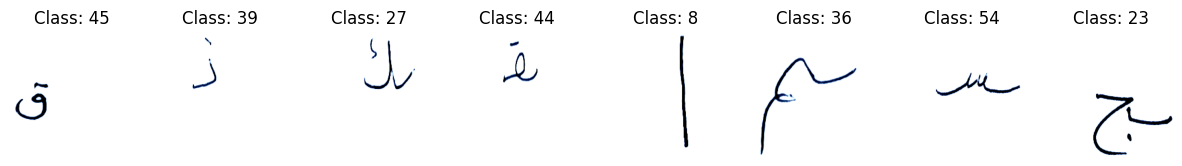

In [15]:
show_images(images, labels)
plt.show()

***MODEL***

In [16]:
#Final Delivery (Running with squeeze and excitation blocks)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class InceptionWithSE(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionWithSE, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(True),
            SEBlock(ch1x1)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(True),
            SEBlock(ch3x3)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(True),
            SEBlock(ch5x5)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
            SEBlock(pool_proj)
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

class GoogLeNetSE(nn.Module):
    def __init__(self, num_classes=65):
        super(GoogLeNetSE, self).__init__()
        self.base_model = models.googlenet(pretrained=True, aux_logits=True, transform_input=False)

        # Replace each Inception module with one that includes SE blocks
        self.base_model.inception3a = InceptionWithSE(192, 64, 96, 128, 16, 32, 32)
        self.base_model.inception3b = InceptionWithSE(256, 128, 128, 192, 32, 96, 64)
        self.base_model.inception4a = InceptionWithSE(480, 192, 96, 208, 16, 48, 64)
        self.base_model.inception4b = InceptionWithSE(512, 160, 112, 224, 24, 64, 64)
        self.base_model.inception4c = InceptionWithSE(512, 128, 128, 256, 24, 64, 64)
        self.base_model.inception4d = InceptionWithSE(512, 112, 144, 288, 32, 64, 64)
        self.base_model.inception4e = InceptionWithSE(528, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5a = InceptionWithSE(832, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5b = InceptionWithSE(832, 384, 192, 384, 48, 128, 128)

        # Replaceing the last fully connected layer to match the number of classes
        self.base_model.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [34]:
#Final Delivery (Running with GridWise Attention)

class GridWiseAttention(nn.Module):
    def __init__(self, in_channels):
        super(GridWiseAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        attention_map = torch.sigmoid(self.conv1(x))  
        return x * attention_map  # Apply attention map to input feature map

class GoogLeNetWithAttention(nn.Module):
    def __init__(self, num_classes=65):
        super(GoogLeNetWithAttention, self).__init__()
        self.base_model = models.googlenet(pretrained=True, aux_logits=True)
        self.attention = GridWiseAttention(512) 

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Forward through the GoogLeNet layers up to the point of attention application
        x = self.base_model.conv1(x)
        x = self.base_model.maxpool1(x)
        x = self.base_model.conv2(x)
        x = self.base_model.conv3(x)
        x = self.base_model.maxpool2(x)
        x = self.base_model.inception3a(x)
        x = self.base_model.inception3b(x)
        x = self.base_model.maxpool3(x)
        x = self.base_model.inception4a(x)
        x = self.base_model.inception4b(x)
        
        # Apply GridWise Attention
        x = self.attention(x)
        
        # Continue through remaining layers
        x = self.base_model.inception4c(x)
        x = self.base_model.inception4d(x)
        x = self.base_model.inception4e(x)
        x = self.base_model.maxpool4(x)
        x = self.base_model.inception5a(x)
        x = self.base_model.inception5b(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.dropout(x)
        x = self.base_model.fc(x)

        return x

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogLeNetWithAttention(num_classes=65).to(device)  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [183]:
#Milestone II Delivery (Running with Region Based Attention)

class RegionBasedAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(RegionBasedAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
class ModifiedGoogLeNetWithRegionAttention(nn.Module):
    def __init__(self, num_classes, use_attention=True):
        super(ModifiedGoogLeNetWithRegionAttention, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        self.use_attention = use_attention
        self.region_attention = RegionBasedAttention(1024)
        
        # Replaceing the last fully connected layer
        in_features = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.googlenet.conv1(x)
        x = self.googlenet.maxpool1(x)
        x = self.googlenet.conv2(x)
        x = self.googlenet.conv3(x)
        x = self.googlenet.maxpool2(x)
        x = self.googlenet.inception3a(x)
        x = self.googlenet.inception3b(x)
        x = self.googlenet.maxpool3(x)
        x = self.googlenet.inception4a(x)
        x = self.googlenet.inception4b(x)
        x = self.googlenet.inception4c(x)
        x = self.googlenet.inception4d(x)
        x = self.googlenet.inception4e(x)
        x = self.googlenet.maxpool4(x)
        x = self.googlenet.inception5a(x)
        x = self.googlenet.inception5b(x)
        
        if self.use_attention:
            x = self.region_attention(x)  # Apply region-based attention

        x = self.googlenet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.googlenet.dropout(x)
        x = self.googlenet.fc(x)
        return x
    
model = ModifiedGoogLeNetWithRegionAttention(num_classes=num_classes, use_attention=True).to(device)

In [224]:
#Milestone II Delivery (Running with Self Attention)

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.scale = (in_channels // 8) ** -0.5

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        query = self.query_conv(x).view(batch_size, -1, height * width)
        key = self.key_conv(x).view(batch_size, -1, height * width)
        value = self.value_conv(x).view(batch_size, -1, height * width)

        attention_scores = torch.bmm(query.permute(0, 2, 1), key)
        attention_scores = F.softmax(attention_scores * self.scale, dim=-1)

        out = torch.bmm(value, attention_scores)
        out = out.view(batch_size, channels, height, width)
        return out + x  

class GoogLeNetWithSelfAttention(nn.Module):
    def __init__(self, num_classes, use_attention=True):
        super(GoogLeNetWithSelfAttention, self).__init__()
        self.base_model = models.googlenet(pretrained=True)
        self.use_attention = use_attention
        
        self.attention = SelfAttention(832)  

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.maxpool1(x)
        x = self.base_model.conv2(x)
        x = self.base_model.conv3(x)
        x = self.base_model.maxpool2(x)
        x = self.base_model.inception3a(x)
        x = self.base_model.inception3b(x)
        x = self.base_model.maxpool3(x)
        x = self.base_model.inception4a(x)
        x = self.base_model.inception4b(x)
        x = self.base_model.inception4c(x)
        x = self.base_model.inception4d(x)
        x = self.base_model.inception4e(x)
        x = self.base_model.maxpool4(x) 

        if self.use_attention:
            x = self.attention(x)  # Apply self-attention after maxpool4

        x = self.base_model.inception5a(x)
        x = self.base_model.inception5b(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.dropout(x)
        x = self.base_model.fc(x)
        return x

model = GoogLeNetWithSelfAttention(num_classes=num_classes, use_attention=True).to(device)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
#Original Model
googlenett = models.googlenet(pretrained=True)
googlenett.fc = nn.Linear(googlenett.fc.in_features, 65)
googlenett = googlenett.to(device)

optimizer = torch.optim.Adam(googlenett.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [20]:
#Final Delivery (Running with Original Vision Transformer Base Patch 16)
vit_transformer = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_transformer = vit_transformer.to(device)

optimizer = torch.optim.Adam(vit_transformer.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [21]:
#Final Delivery (Running with Swin Transformer Base Patch 4, Window 7)
swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=65)
swin_transformer = swin_transformer.to(device)

optimizer = torch.optim.Adam(swin_transformer.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [18]:
#Final Delivery (Running with squeeze and excitation blocks)
googlenet_se = GoogLeNetSE(num_classes=65).to(device)

optimizer = torch.optim.Adam(googlenet_se.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 190MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them


In [93]:
optimizer = torch.optim.Adam(googlenett.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [27]:
last_layer = googlenett.fc# Check if the last layer is an instance of nn.Linear

if isinstance(last_layer, nn.Linear):
    in_features = last_layer.in_features
    googlenett.fc = nn.Linear(in_features, num_classes)
else:
    raise ValueError("The last layer of the model is not Linear, please adjust the code accordingly.")

In [19]:
# List of true labels and their corresponding predicted labels
true_labels = [64, 42, 37, 64, 14, 24, 64, 64, 40, 9, 14, 41, 57, 56, 54, 49, 58, 11, 13, 46, 47, 2, 57, 3, 37, 57, 11, 57, 17, 39, 46, 43, 57, 18, 59, 37, 45, 57, 35, 26, 45, 18, 64, 16, 53, 58, 64, 57, 57, 18, 64, 16, 57, 35, 45, 43, 57, 9, 57, 23, 0, 64, 36, 15, 23, 2, 7, 57, 57, 13, 53, 57, 58, 13, 15, 57, 28, 0, 9, 57, 57, 7, 2, 14, 37, 10, 57, 14, 52, 16, 25, 57, 34, 15, 18, 31, 16, 57, 22, 37, 57, 53, 27, 18, 37, 59, 58, 47, 14, 53, 23, 33, 57, 13, 51, 57, 63, 57, 57, 47, 57, 35, 21, 8, 57, 64, 46, 57, 53, 42, 15, 14, 64, 64, 57, 57, 57, 1, 13, 10, 2, 9, 14, 1, 17, 57, 15, 57, 56, 18, 4, 43, 52, 55, 57, 24, 47, 43, 11, 57, 43, 18, 18, 15, 6, 8, 64, 56, 13, 42, 15, 40, 57, 34, 37, 57, 64, 64, 44, 39, 0, 57, 37, 43, 17, 44, 43, 14, 57, 14, 59, 57, 64, 37, 64, 23, 35, 64, 19, 15, 47, 57, 23, 17, 42, 57, 57, 64, 36, 23, 45, 54, 13, 45, 11, 31, 53, 58, 64, 16, 11, 14, 29, 64, 29, 57, 6, 64, 57, 57, 46, 37, 31, 14, 43, 13, 36, 64, 42, 56, 51, 11, 18, 20, 15, 23, 17, 44, 16, 37, 64, 64, 57, 27, 1, 37, 42, 14, 51, 37, 18, 17, 37, 18, 46, 4, 14, 18, 13, 16, 57, 57, 43, 19, 11, 46, 56, 64, 57, 22, 18, 48, 23, 34, 32, 13, 14, 15]

predicted_labels = [26, 60, 50, 62, 31, 22, 62, 26, 17, 61, 34, 39, 56, 57, 52, 50, 56, 10, 33, 13, 14, 60, 56, 5, 35, 56, 10, 56, 16, 41, 26, 50, 56, 16, 60, 49, 43, 56, 48, 2, 18, 15, 26, 43, 54, 15, 62, 56, 56, 15, 26, 17, 56, 48, 36, 44, 56, 61, 56, 25, 50, 26, 38, 18, 24, 35, 8, 56, 56, 32, 55, 56, 21, 24, 18, 56, 13, 59, 12, 56, 56, 8, 60, 34, 50, 11, 56, 14, 54, 17, 10, 56, 41, 18, 15, 31, 17, 56, 12, 4, 56, 54, 1, 45, 4, 4, 56, 31, 15, 41, 16, 15, 5, 7, 62, 57, 33, 18, 40, 27, 56, 29, 50, 57, 18, 15, 32, 17, 56, 56, 49, 48, 10, 41, 57, 51, 56, 62, 56, 24, 15, 3, 25, 31, 33, 40, 31, 47, 14, 1, 33, 38, 62, 42, 57, 56, 22, 15, 51, 25, 34, 33, 40, 31, 18, 20, 60, 25, 16, 37, 62, 62, 56, 44, 41, 50, 42, 31, 47, 1, 33, 38, 62, 42, 56, 57, 17, 16, 4, 15, 13, 32, 17]

# Count occurrences of each pair (true_label, predicted_label)
label_pairs = list(zip(true_labels, predicted_labels))
label_counts = {}
for pair in label_pairs:
    if pair in label_counts:
        label_counts[pair] += 1
    else:
        label_counts[pair] = 1

# Create a 65x65 matrix initialized with zeros
num_classes = 65
noise_transition_matrix = np.zeros((num_classes, num_classes))

# Fill in the matrix with the normalized counts
for i in range(num_classes):
    for j in range(num_classes):
        count = label_counts.get((i, j), 0)
        total_count = sum([value for key, value in label_counts.items() if key[0] == i])
        if total_count > 0:
            noise_transition_matrix[i, j] = count / total_count

In [20]:
noise_transition_matrix = torch.tensor(noise_transition_matrix).float().to(device)

In [29]:
#Milestone II (Running with Label Smoothing Noisy Handeling)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weights = input.new_ones(input.size()) * (self.smoothing / (input.size(-1) - 1))
        weights.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weights * log_prob).sum(dim=-1).mean()
        return loss


In [ ]:
#Milestone II (Running with Focal Loss Noisy Handeling)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Alpha can be a scalar or a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction=self.reduction, weight=self.alpha)
        pt = torch.exp(-ce_loss)  # Probabilities of being correctly classified
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [31]:
#Milestone II (Running with JNPL Noisy Handeling)

def jnpl_loss(outputs, labels, noise_transition_matrix):
    """
    Joint Noise and Pattern Learning (JNPL) loss function.
    Combines cross-entropy loss with noise transition matrix.
    """
    ce_loss = nn.functional.cross_entropy(outputs, labels)
    
    num_classes = outputs.size(1)
    one_hot_labels = nn.functional.one_hot(labels, num_classes=num_classes).float()
    
    # Apply noise transition matrix to one-hot encoded labels
    noisy_labels = torch.matmul(one_hot_labels, noise_transition_matrix).float()
    
    # Compute noisy cross-entropy loss
    noisy_ce_loss = nn.functional.cross_entropy(outputs, noisy_labels)
    
    # Combine cross-entropy loss and noisy cross-entropy loss
    jnpl_loss = ce_loss + noisy_ce_loss
    
    return jnpl_loss

criterion = jnpl_loss

In [141]:
torch.cuda.empty_cache()

In [21]:
num_epochs = 10
desired_training_accuracy = 99.999
early_stopping_threshold = 5  
early_stopping_counter = 0
best_val_loss = float('inf')

In [22]:
# Lists to store training and validation metrics for plotting curves
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [154]:
#Original model + regularization + JNPL
for epoch in range(num_epochs):
    googlenett.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenett(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    googlenett.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenett(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

googlenett.eval()
correct = 0
total = 0
false = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = googlenett(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        incorrect_indices = (predicted != labels).nonzero()
        
        for idx in incorrect_indices:
            false.append((inputs[idx], labels[idx], predicted[idx]))

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Epoch 1/10, Batch 100/4256, Training Loss: 0.11400887551950291, Training Accuracy: 96.5
Epoch 1/10, Batch 200/4256, Training Loss: 0.0811958992446307, Training Accuracy: 97.0
Epoch 1/10, Batch 300/4256, Training Loss: 0.10343385581742041, Training Accuracy: 96.70833333333333
Epoch 1/10, Batch 400/4256, Training Loss: 0.09380828432389535, Training Accuracy: 96.84375
Epoch 1/10, Batch 500/4256, Training Loss: 0.11852001851191744, Training Accuracy: 96.6
Epoch 1/10, Batch 600/4256, Training Loss: 0.10036894881865009, Training Accuracy: 96.64583333333333
Epoch 1/10, Batch 700/4256, Training Loss: 0.09081606607185677, Training Accuracy: 96.73214285714286
Epoch 1/10, Batch 800/4256, Training Loss: 0.11299739206093364, Training Accuracy: 96.671875
Epoch 1/10, Batch 900/4256, Training Loss: 0.11093706923536956, Training Accuracy: 96.625
Epoch 1/10, Batch 1000/4256, Training Loss: 0.13848298919387161, Training Accuracy: 96.55
Epoch 1/10, Batch 1100/4256, Training Loss: 0.13900459099444562, Trai

In [ ]:
#Original Vision Transformer Base Patch 16 + regularization
for epoch in range(num_epochs):
    vit_transformer.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    vit_transformer.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_transformer(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

vit_transformer.eval()
correct = 0
total = 0
false = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_transformer(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        incorrect_indices = (predicted != labels).nonzero()
        
        for idx in incorrect_indices:
            false.append((inputs[idx], labels[idx], predicted[idx]))

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

In [159]:
#Swin Transformer Base Patch 4, Window 7 + regularization
for epoch in range(num_epochs):
    swin_transformer.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = swin_transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    swin_transformer.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = swin_transformer(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

swin_transformer.eval()
correct = 0
total = 0
false = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = swin_transformer(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        incorrect_indices = (predicted != labels).nonzero()
        
        for idx in incorrect_indices:
            false.append((inputs[idx], labels[idx], predicted[idx]))

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Epoch 1/4, Batch 100/4256, Training Loss: 0.10824084250285523, Training Accuracy: 96.625
Epoch 1/4, Batch 200/4256, Training Loss: 0.06112136279902188, Training Accuracy: 97.25
Epoch 1/4, Batch 300/4256, Training Loss: 0.08146964549232508, Training Accuracy: 97.25
Epoch 1/4, Batch 400/4256, Training Loss: 0.10114525816374226, Training Accuracy: 97.125
Epoch 1/4, Batch 500/4256, Training Loss: 0.09287706794857513, Training Accuracy: 97.075
Epoch 1/4, Batch 600/4256, Training Loss: 0.07898221154173371, Training Accuracy: 97.10416666666667
Epoch 1/4, Batch 700/4256, Training Loss: 0.12733199222013356, Training Accuracy: 97.08928571428571
Epoch 1/4, Batch 800/4256, Training Loss: 0.05767473917512689, Training Accuracy: 97.1875
Epoch 1/4, Batch 900/4256, Training Loss: 0.09920467294985429, Training Accuracy: 97.16666666666667
Epoch 1/4, Batch 1000/4256, Training Loss: 0.09066864016087493, Training Accuracy: 97.1125
Epoch 1/4, Batch 1100/4256, Training Loss: 0.11049629109125818, Training Acc

In [24]:
#Original Model + regularization + squeeze and excitation blocks
for epoch in range(num_epochs):
    googlenet_se.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet_se(inputs)
        
        output_main = outputs.logits
        output_aux1 = outputs.aux_logits1
        output_aux2 = outputs.aux_logits2

        # Loss computation
        loss_main = criterion(output_main, labels)
        loss_aux1 = criterion(output_aux1, labels)
        loss_aux2 = criterion(output_aux2, labels)
        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2  # Weighted sum of the main and auxiliary losses

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(output_main.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    googlenet_se.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenet_se(inputs)
            
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

googlenet_se.eval()
correct = 0
total = 0
false = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = googlenet_se(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        incorrect_indices = (predicted != labels).nonzero()
        
        for idx in incorrect_indices:
            false.append((inputs[idx], labels[idx], predicted[idx]))

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Epoch 1/10, Batch 100/4256, Training Loss: 7.956800265312195, Training Accuracy: 3.625
Epoch 1/10, Batch 200/4256, Training Loss: 6.949565348625183, Training Accuracy: 6.25
Epoch 1/10, Batch 300/4256, Training Loss: 6.4604638671875, Training Accuracy: 7.458333333333333
Epoch 1/10, Batch 400/4256, Training Loss: 6.010285162925721, Training Accuracy: 9.625
Epoch 1/10, Batch 500/4256, Training Loss: 5.565513081550598, Training Accuracy: 12.2
Epoch 1/10, Batch 600/4256, Training Loss: 5.059595451354981, Training Accuracy: 15.541666666666666
Epoch 1/10, Batch 700/4256, Training Loss: 4.609597980976105, Training Accuracy: 19.0
Epoch 1/10, Batch 800/4256, Training Loss: 4.135918455123901, Training Accuracy: 22.453125
Epoch 1/10, Batch 900/4256, Training Loss: 3.8309505653381346, Training Accuracy: 25.569444444444443
Epoch 1/10, Batch 1000/4256, Training Loss: 3.541713809967041, Training Accuracy: 28.75
Epoch 1/10, Batch 1100/4256, Training Loss: 3.1874599504470824, Training Accuracy: 31.57954

In [23]:
#Genaric
model.eval()
correct = 0
total = 0
false = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        incorrect_indices = (predicted != labels).nonzero()
        
        for idx in incorrect_indices:
            false.append((inputs[idx], labels[idx], predicted[idx]))

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Test Accuracy: 1.432933991073526%


**Save Weights**

In [160]:
torch.save(googlenett.state_dict(), 'googlenett_weights.pth')
torch.save(swin_transformer.state_dict(), 'swin_transformer_weights.pth')
torch.save(googlenet_se.state_dict(), 'googlenet_se_weights.pth')
torch.save(vit_transformer.state_dict(), 'vit_transformer_weights.pth')

In [27]:
from IPython.display import FileLink
FileLink('swin_transformer_weights.pth')
FileLink('googlenet_se_weights.pth')
FileLink('googlenett_weights.pth')
FileLink('vit_transformer_weights.pth')

/kaggle/working/googlenet_se_weights.pth

In [ ]:
import os
print(os.listdir()) 


**Ensemble 1**

In [ ]:
# Original Model & JNPL + Swin Transformer + squeeze and excitation blocks
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        
        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
y_pred1

In [ ]:
y_pred2

In [ ]:
y_pred3

In [ ]:
def vote(finall):
    """
    Perform a vote on each element of the given lists.
    In case of a tie, the value from the first list is chosen.
    
    Returns:
    - List containing the voted values.
    """
    result = []
    list_len = len(finall[0])

    for i in range(list_len):
        # Count occurrences of each element in the current position
        counts = {}
        for lst in finall:
            value = lst[i]
            counts[value] = counts.get(value, 0) + 1
        
        # Find the element with the maximum count
        max_count = max(counts.values())
        candidates = [key for key, count in counts.items() if count == max_count]
        
        # Choose the winner, or use the value from the first list in case of a tie
        winner = candidates[0] if len(candidates) == 1 else finall[0][i]
        result.append(winner)

    return result

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions)

In [ ]:
len(ensemble_predictions)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, ensemble_predictions)

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, ensemble_predictions, average='weighted')
unweighted_precision, unweighted_recall, unweighted_f1_score, _ = precision_recall_fscore_support(y_true, ensemble_predictions, average='macro')

print("Weighted Precision:", precision * 100)
print("Weighted Recall:", recall * 100)
print("Weighted F1 Score:", f1_score * 100)
print("Unweighted Precision:", unweighted_precision * 100)
print("Unweighted Recall:", unweighted_recall * 100)
print("Unweighted F1 Score:", unweighted_f1_score * 100)

# Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Ensemble 2**

In [ ]:
# Original Model & JNPL + Swin Transformer + VIT 
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        
        output3 = vit_transformer(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

***VISUALIZE THE MODEL***

In [61]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

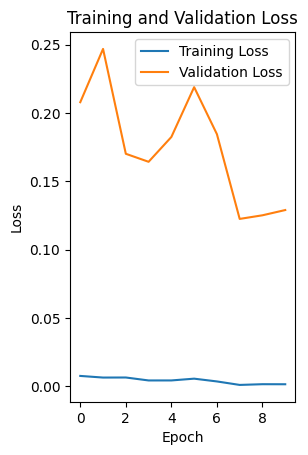

In [62]:
# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

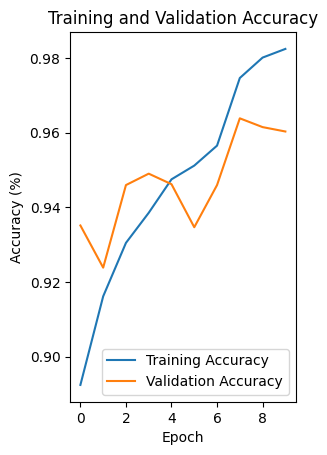

In [63]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

In [64]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [65]:
predictions = []  
targets = []     

for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted_val = torch.max(outputs.data, 1)
    predictions.append(predicted_val.cpu().numpy())
    targets.append(labels.cpu().numpy())

from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = np.concatenate(predictions)  # predicted labels
y_true = np.concatenate(targets)  # true labels

conf_mat = confusion_matrix(y_true, y_pred)


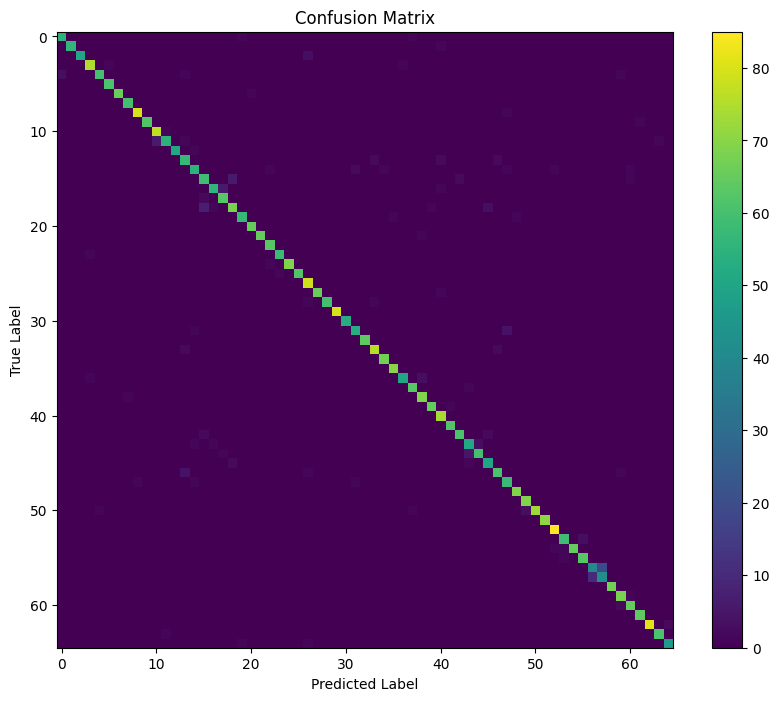

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [67]:
from sklearn.metrics import precision_recall_fscore_support
y_pred, y_true = np.concatenate(predictions), np.concatenate(targets)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
unweighted_precision, unweighted_recall, unweighted_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print("Weighted Precision:", precision * 100)
print("Weighted Recall:", recall * 100)
print("Weighted F1 Score:", f1_score * 100)
print("Unweighted Precision:", unweighted_precision * 100)
print("Unweighted Recall:", unweighted_recall * 100)
print("Unweighted F1 Score:", unweighted_f1_score * 100)

Weighted Precision: 96.10184676237287
Weighted Recall: 96.02820211515863
Weighted F1 Score: 96.02130822610897
Unweighted Precision: 95.98739640102781
Unweighted Recall: 95.87671888275298
Unweighted F1 Score: 95.88662265353048


In [69]:
print("False predictions:")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        print("True Label:", y_true[i], "- Predicted Label:", y_pred[i])

False predictions:
True Label: 57 - Predicted Label: 56
True Label: 27 - Predicted Label: 40
True Label: 15 - Predicted Label: 18
True Label: 4 - Predicted Label: 13
True Label: 57 - Predicted Label: 56
True Label: 19 - Predicted Label: 48
True Label: 14 - Predicted Label: 31
True Label: 53 - Predicted Label: 55
True Label: 11 - Predicted Label: 10
True Label: 14 - Predicted Label: 47
True Label: 47 - Predicted Label: 8
True Label: 33 - Predicted Label: 13
True Label: 36 - Predicted Label: 3
True Label: 19 - Predicted Label: 35
True Label: 18 - Predicted Label: 45
True Label: 4 - Predicted Label: 59
True Label: 53 - Predicted Label: 55
True Label: 0 - Predicted Label: 19
True Label: 11 - Predicted Label: 10
True Label: 2 - Predicted Label: 26
True Label: 46 - Predicted Label: 13
True Label: 2 - Predicted Label: 26
True Label: 1 - Predicted Label: 40
True Label: 16 - Predicted Label: 17
True Label: 25 - Predicted Label: 23
True Label: 50 - Predicted Label: 49
True Label: 16 - Predicted 

***PREDICTIONS***

In [117]:
def nameToLabel(name):
  return "_".join(name.replace('.', '_').split('_')[1:3])

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()

    # Ensure image is in range [0, 1] and has the correct shape
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image.cpu().numpy().squeeze().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
    else:
        image = image.cpu().numpy().squeeze().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [118]:
labels_dict = {}

for category in sorted(os.listdir(train_dir), key=lambda x: int(x)):
    for picture in os.listdir(train_dir + '/' + category):
      labels_dict[category] = nameToLabel(picture)
      break
labels_dict

{'0': 'heh_middle',
 '1': 'noon_end',
 '2': 'ain_begin',
 '3': 'ain_end',
 '4': 'ain_middle',
 '5': 'ain_regular',
 '6': 'alif_end',
 '7': 'alif_hamza',
 '8': 'alif_regular',
 '9': 'beh_begin',
 '10': 'beh_end',
 '11': 'beh_middle',
 '12': 'beh_regular',
 '13': 'dal_end',
 '14': 'dal_regular',
 '15': 'feh_begin',
 '16': 'feh_end',
 '17': 'feh_middle',
 '18': 'feh_regular',
 '19': 'heh_begin',
 '20': 'heh_end',
 '21': 'heh_regular',
 '22': 'jeem_begin',
 '23': 'jeem_end',
 '24': 'jeem_middle',
 '25': 'jeem_regular',
 '26': 'kaf_begin',
 '27': 'kaf_end',
 '28': 'kaf_middle',
 '29': 'kaf_regular',
 '30': 'lam_alif',
 '31': 'lam_begin',
 '32': 'lam_end',
 '33': 'lam_middle',
 '34': 'lam_regular',
 '35': 'meem_begin',
 '36': 'meem_end',
 '37': 'meem_middle',
 '38': 'meem_regular',
 '39': 'noon_begin',
 '40': 'noon_middle',
 '41': 'noon_regular',
 '42': 'qaf_begin',
 '43': 'qaf_end',
 '44': 'qaf_middle',
 '45': 'qaf_regular',
 '46': 'raa_end',
 '47': 'raa_regular',
 '48': 'sad_begin',
 '49':

In [119]:
print(false[0][0].shape)

torch.Size([1, 3, 224, 224])


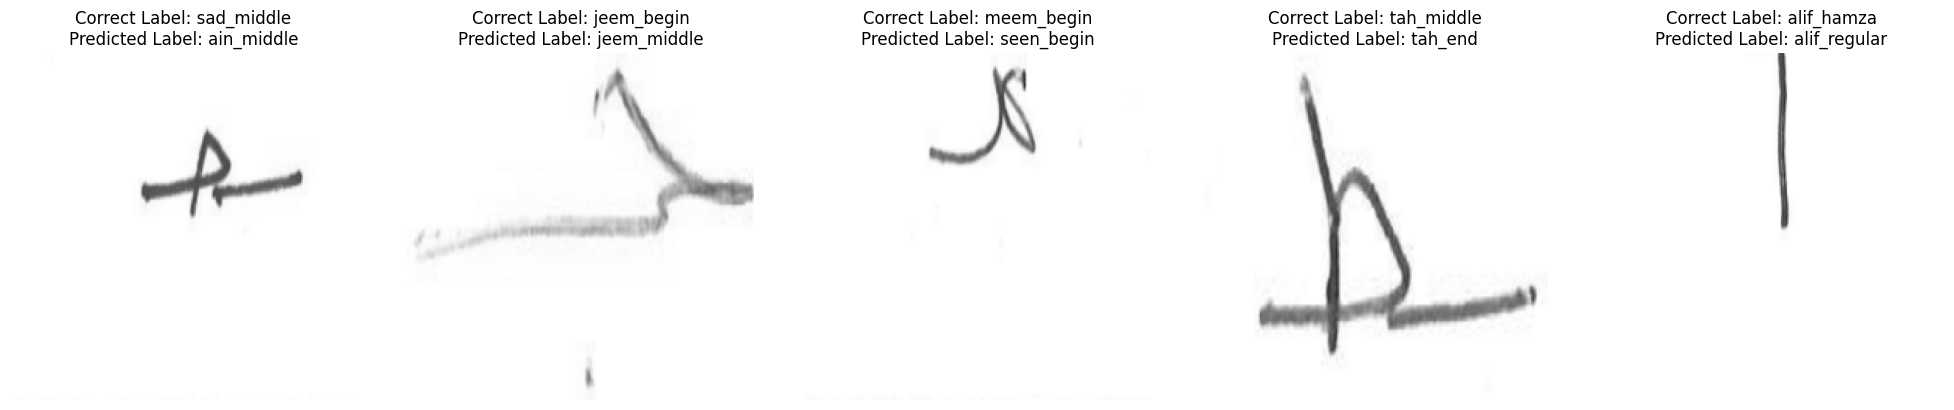

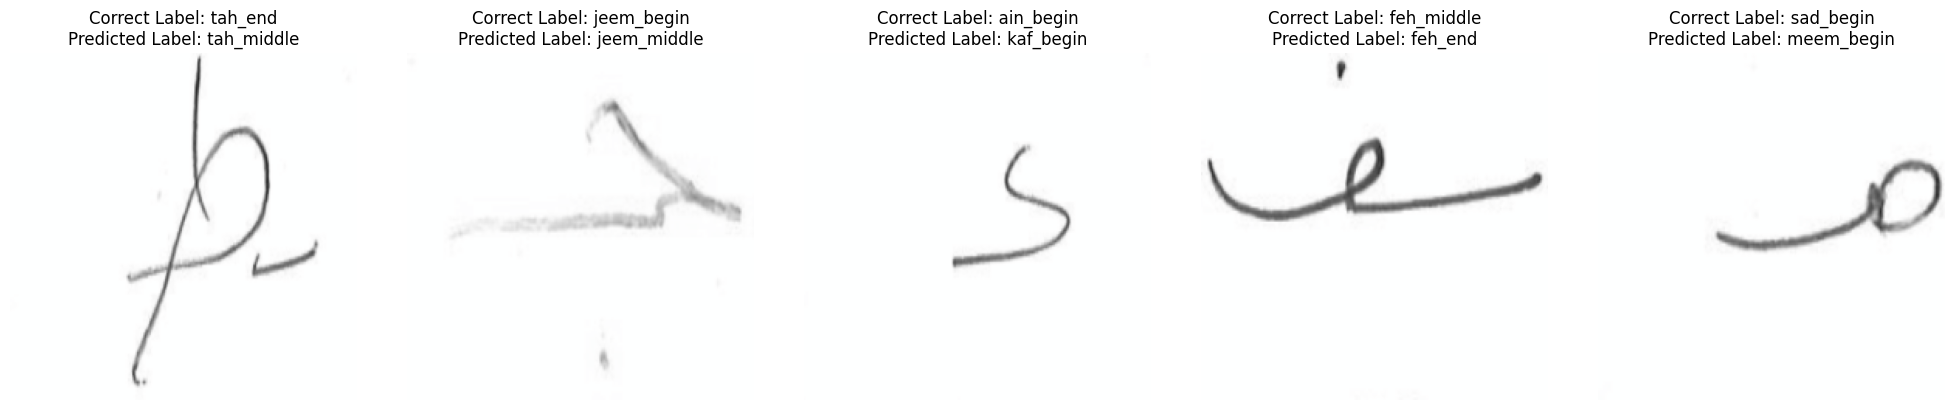

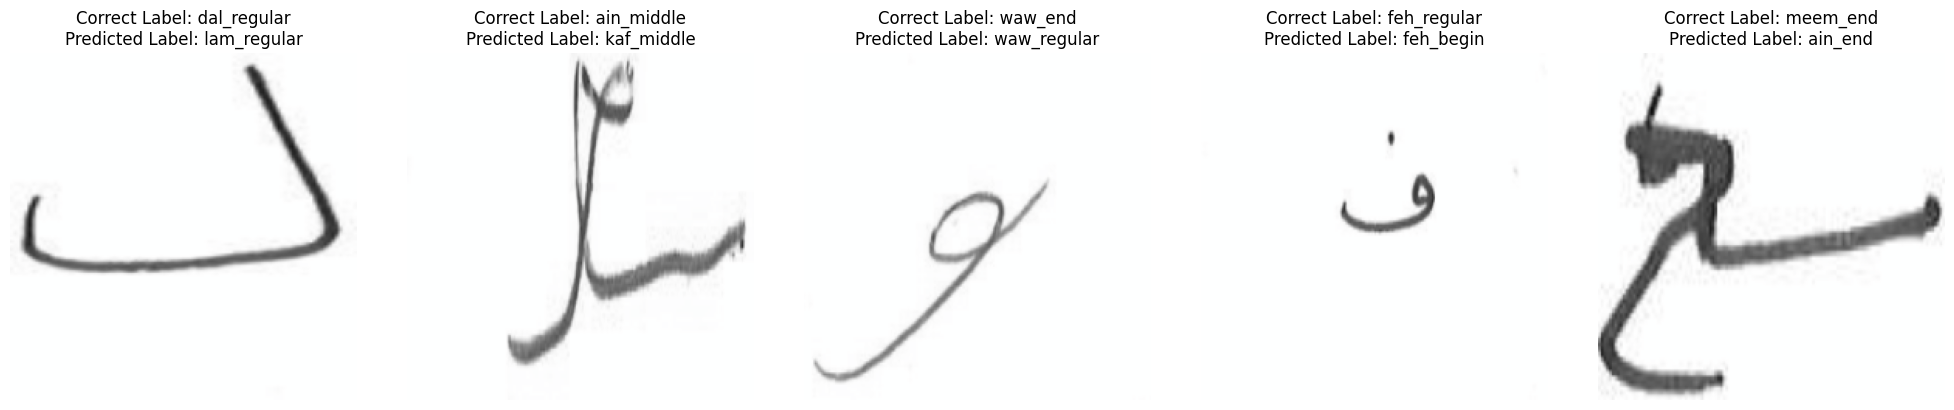

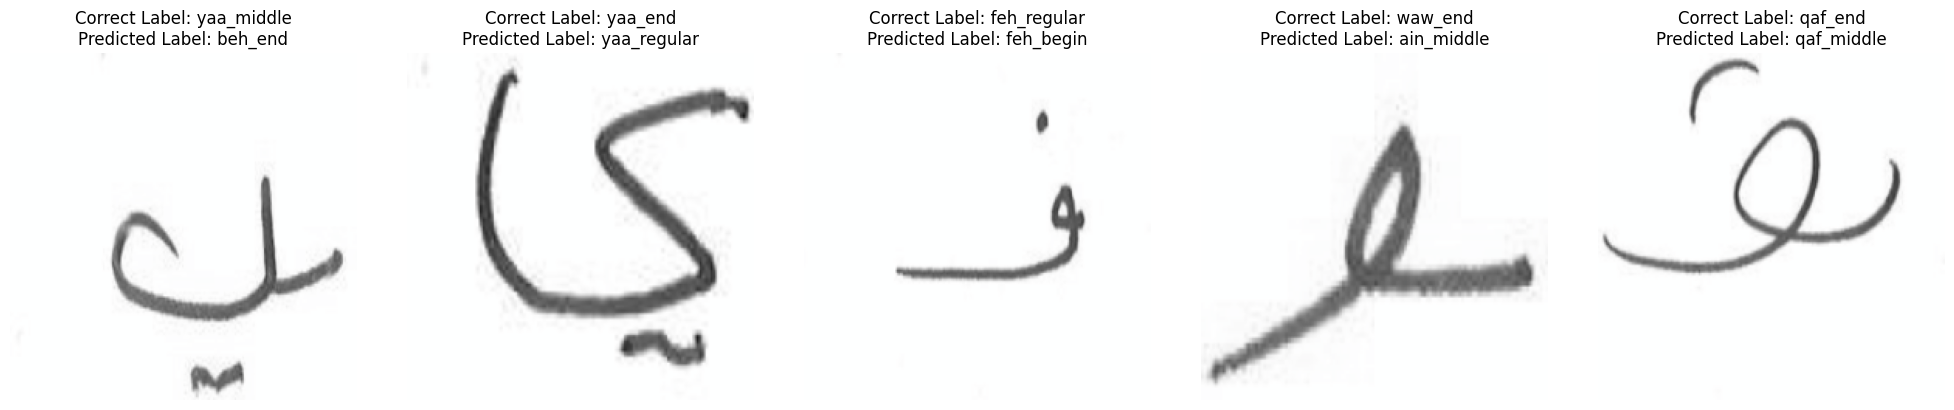

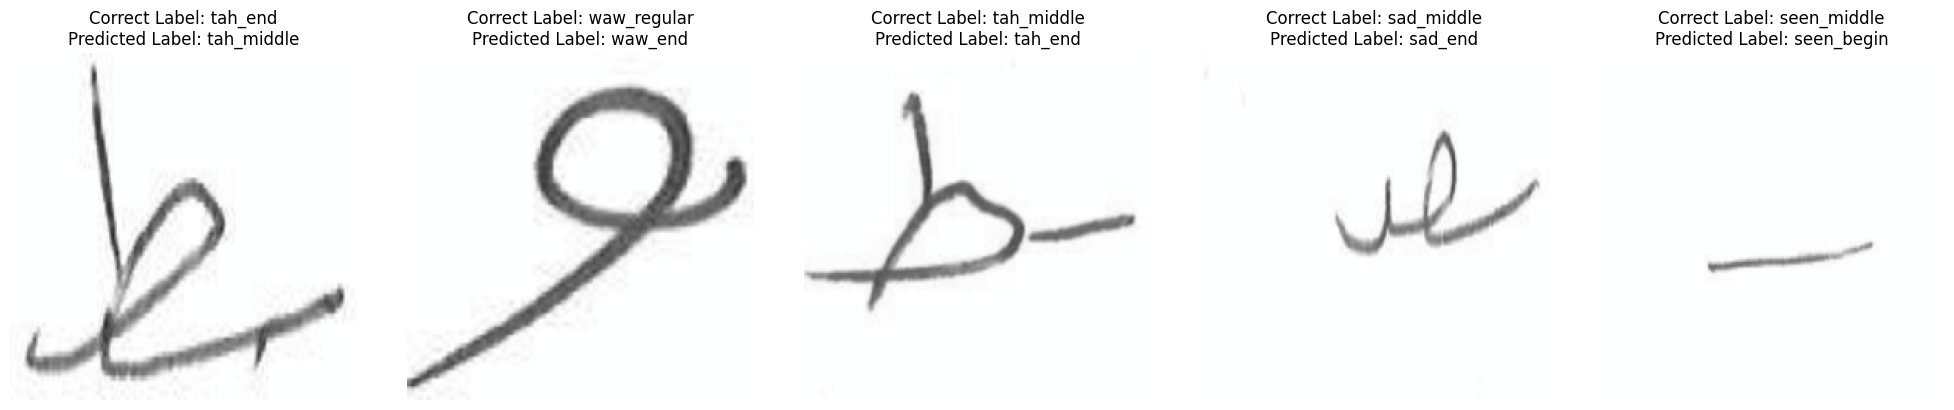

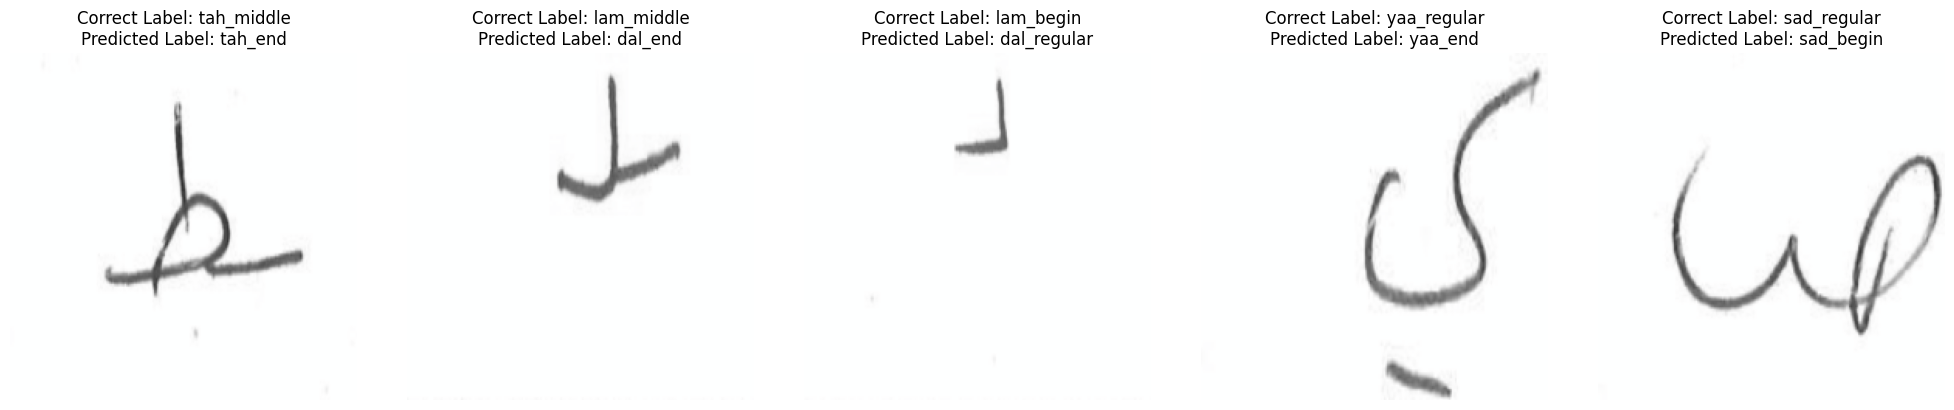

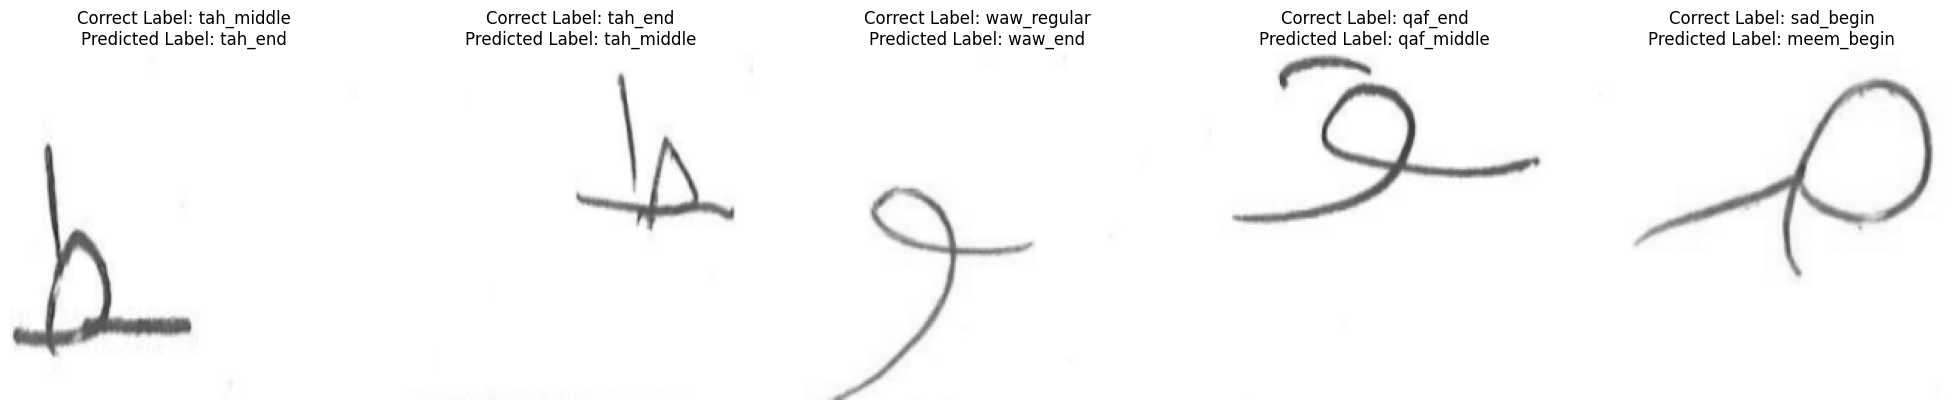

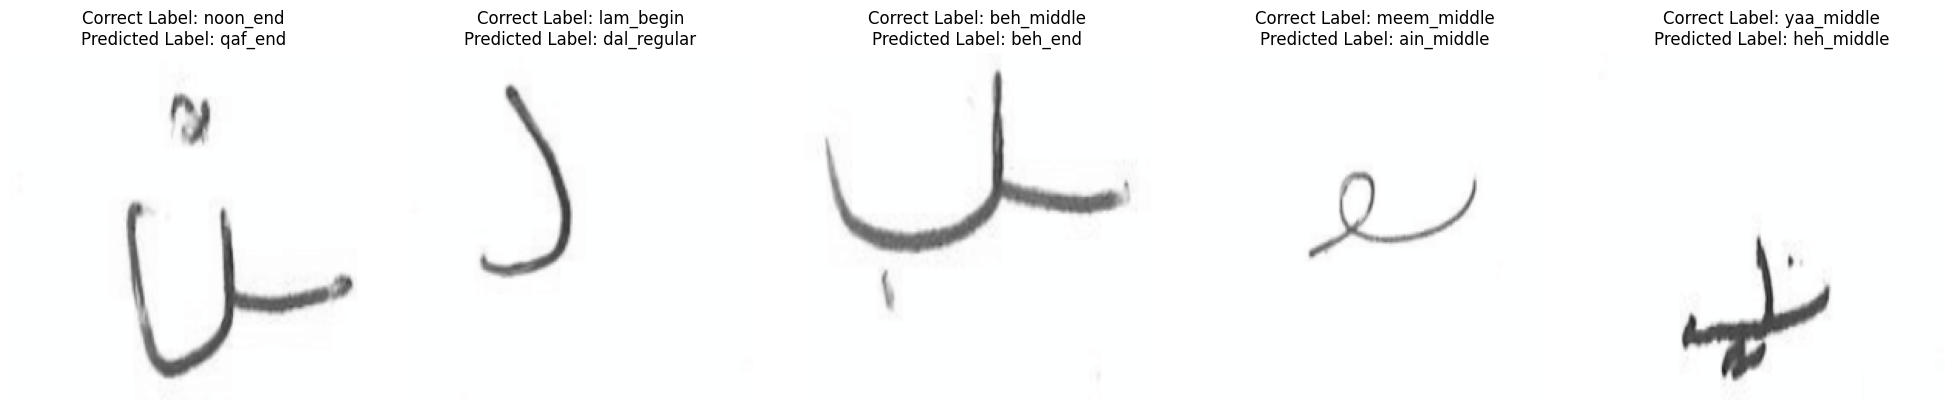

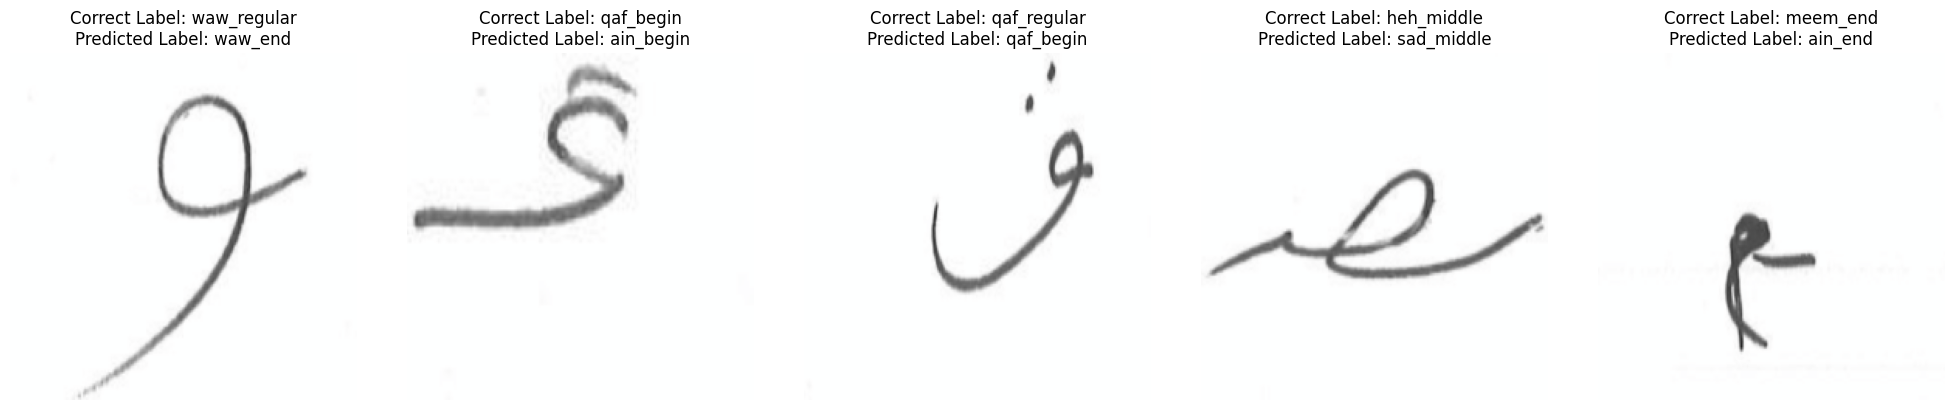

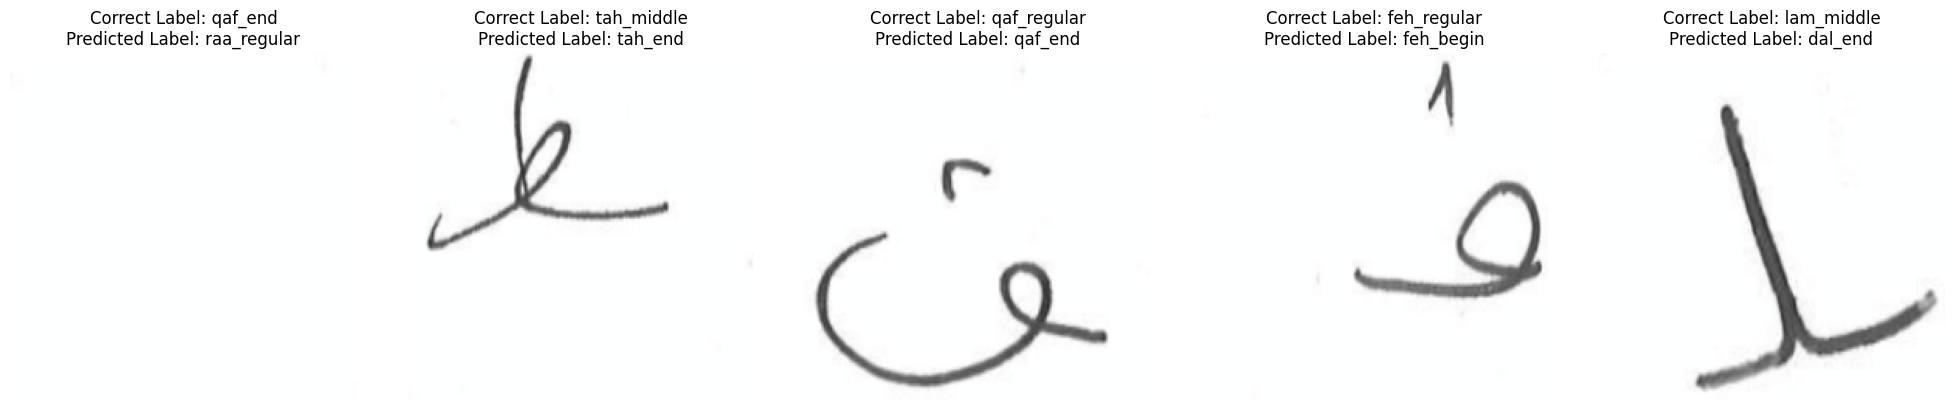

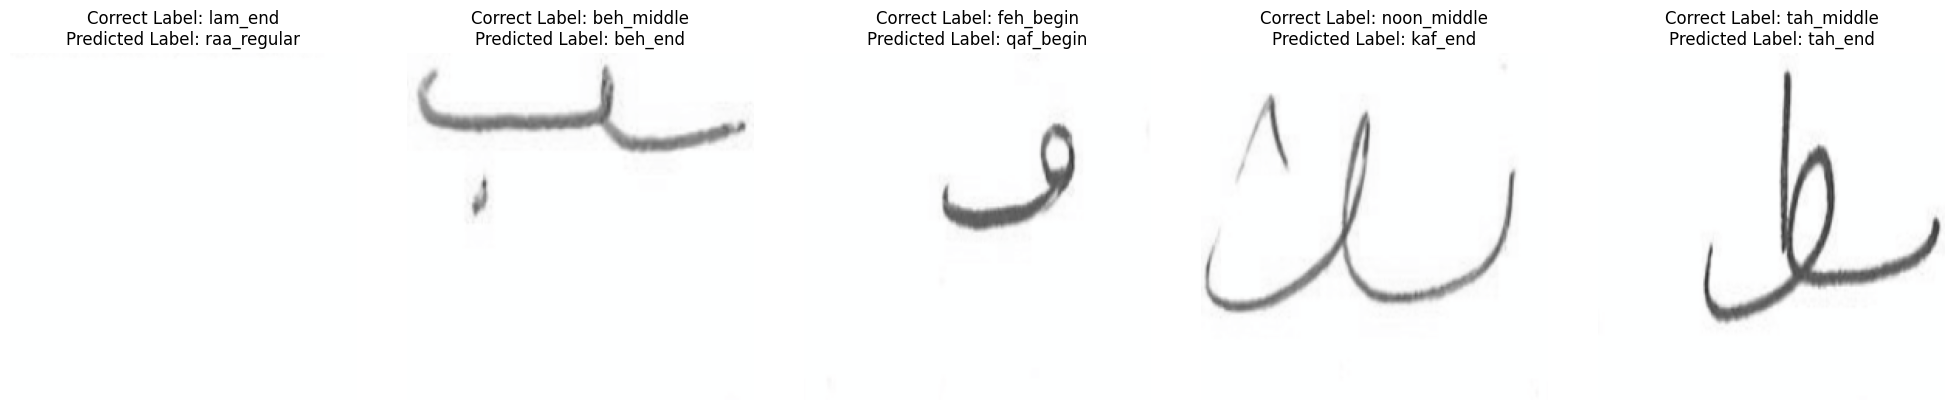

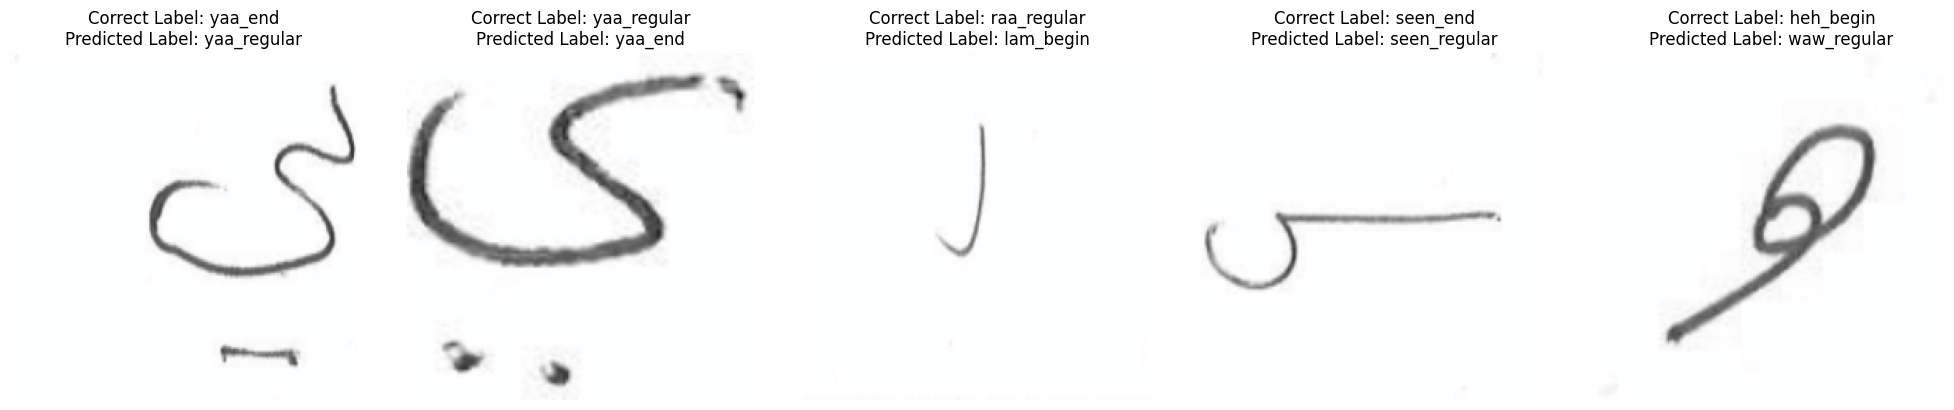

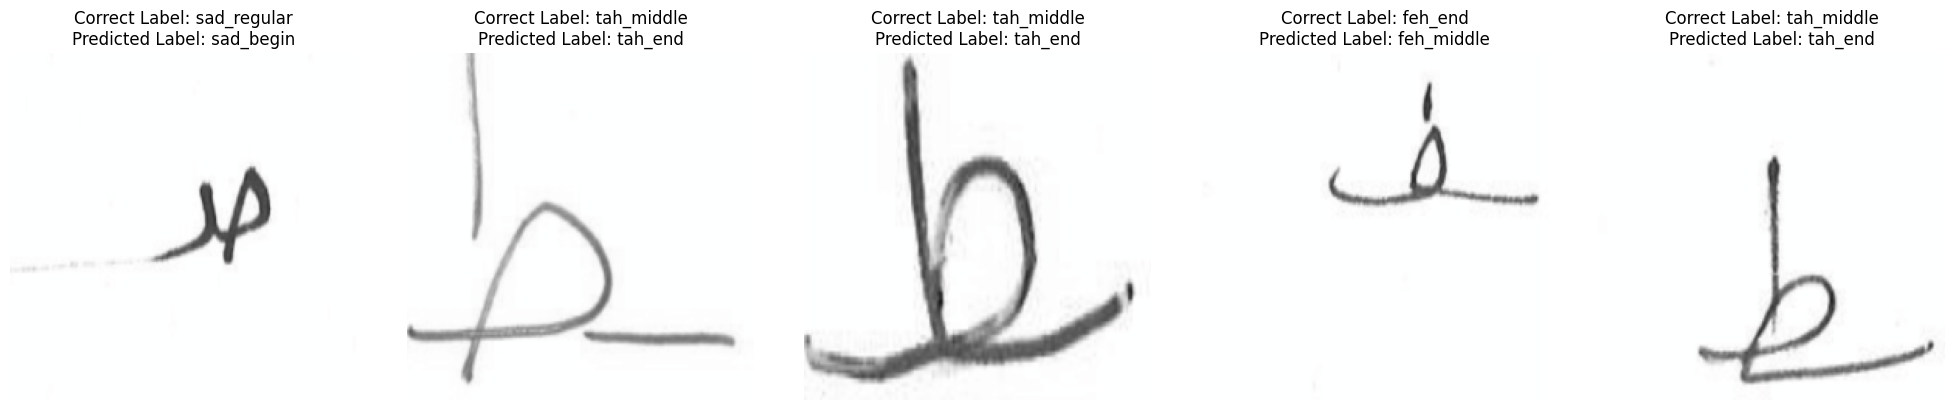

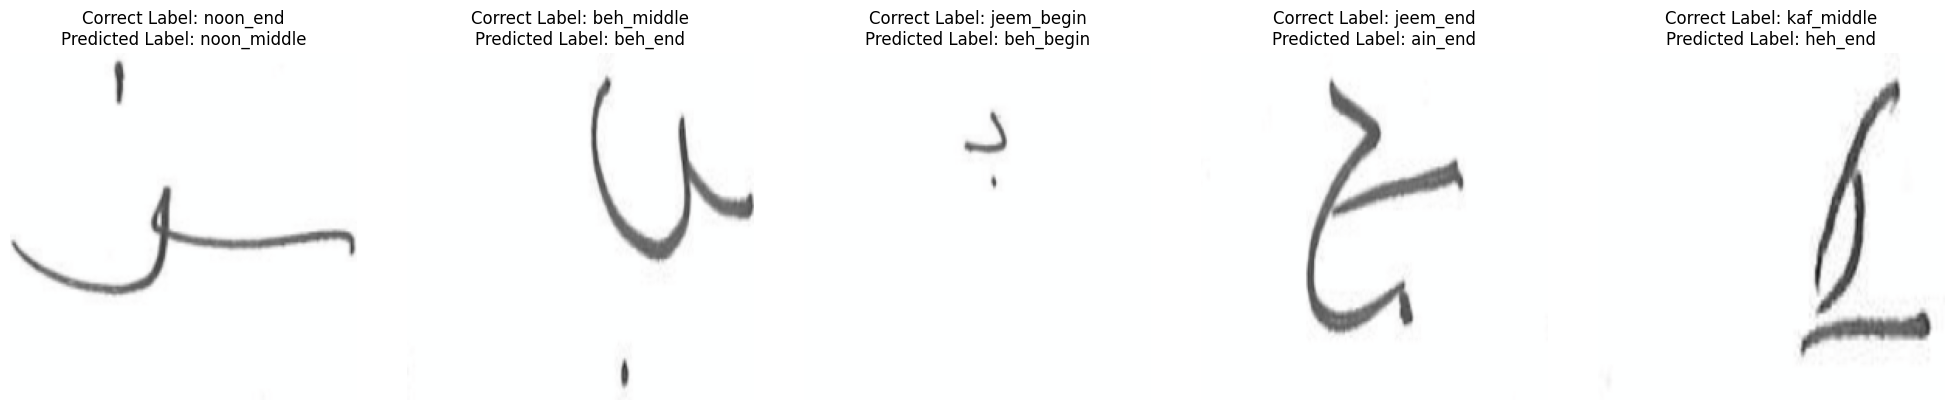

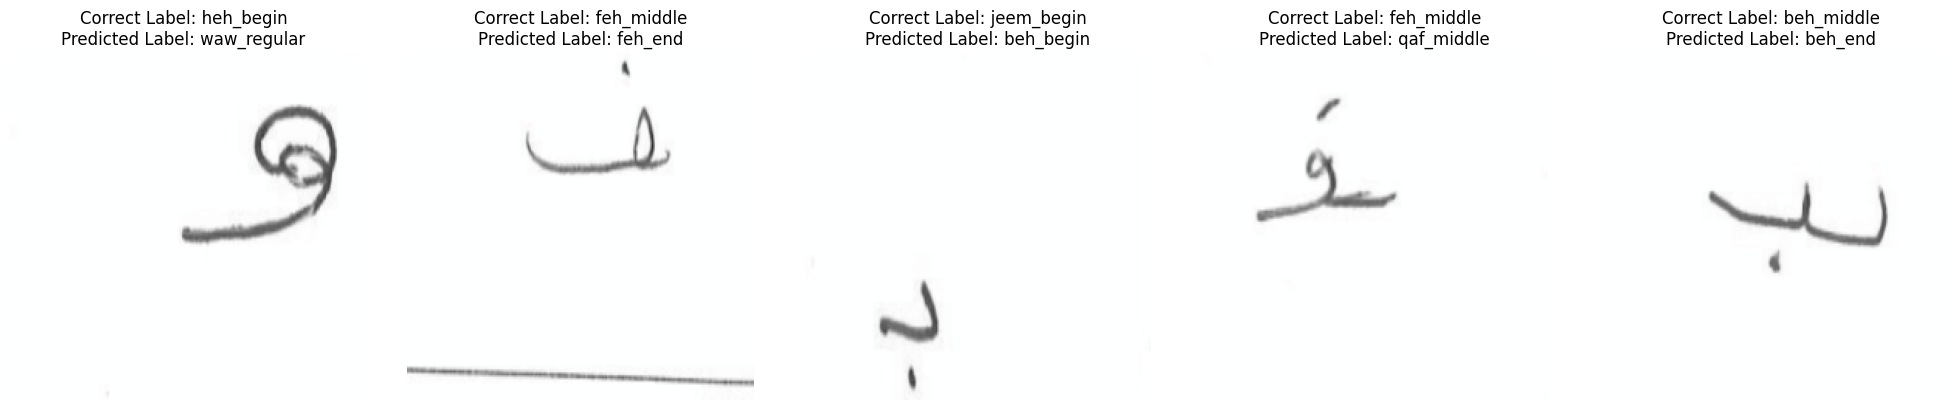

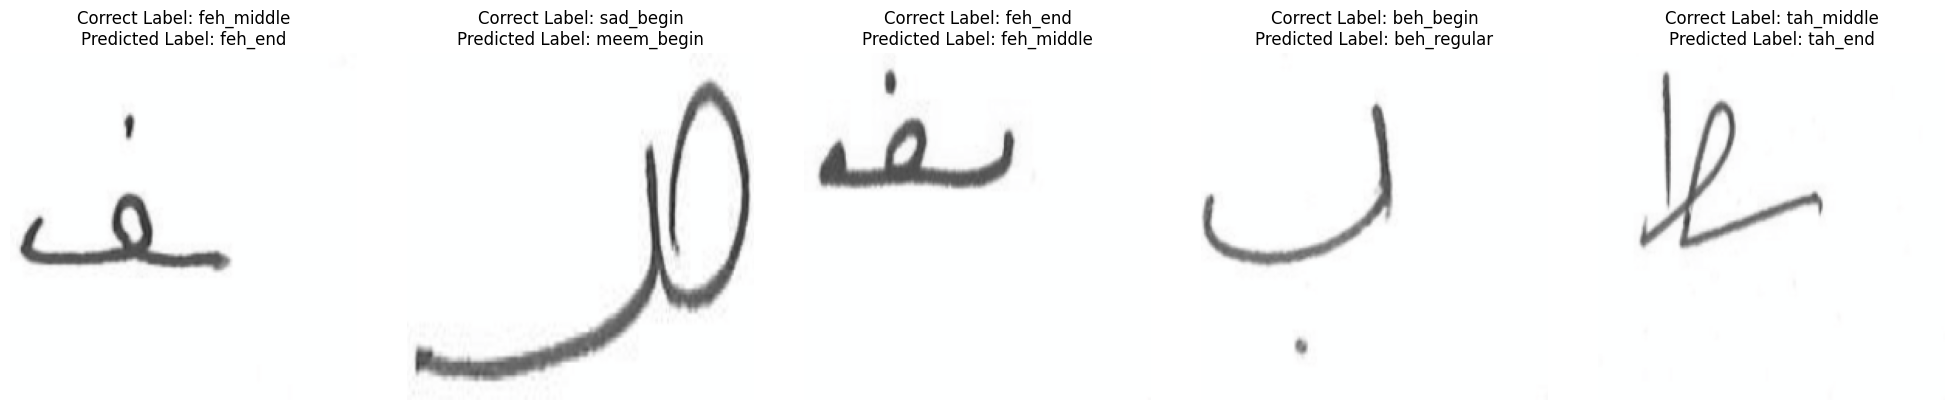

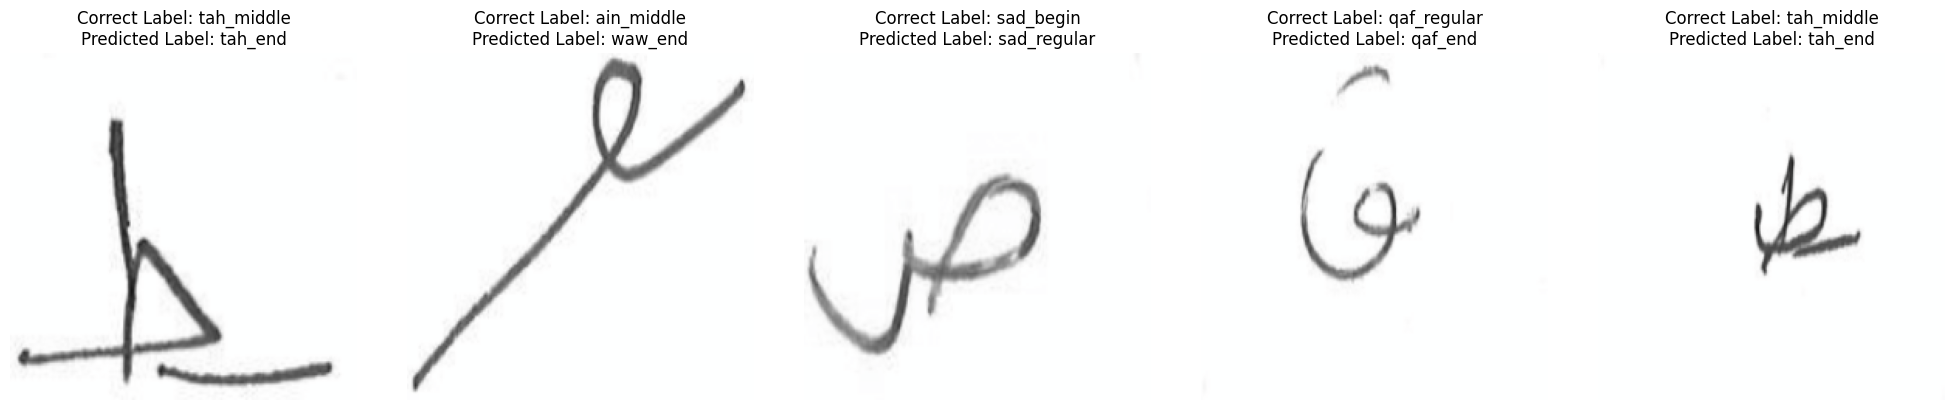

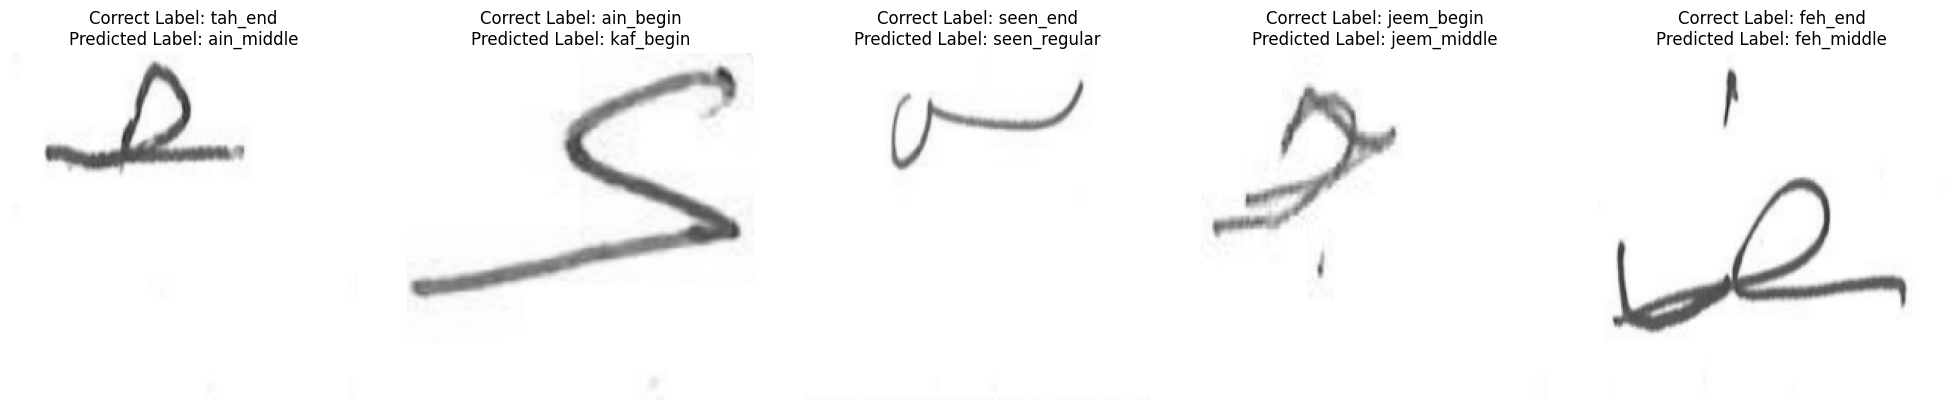

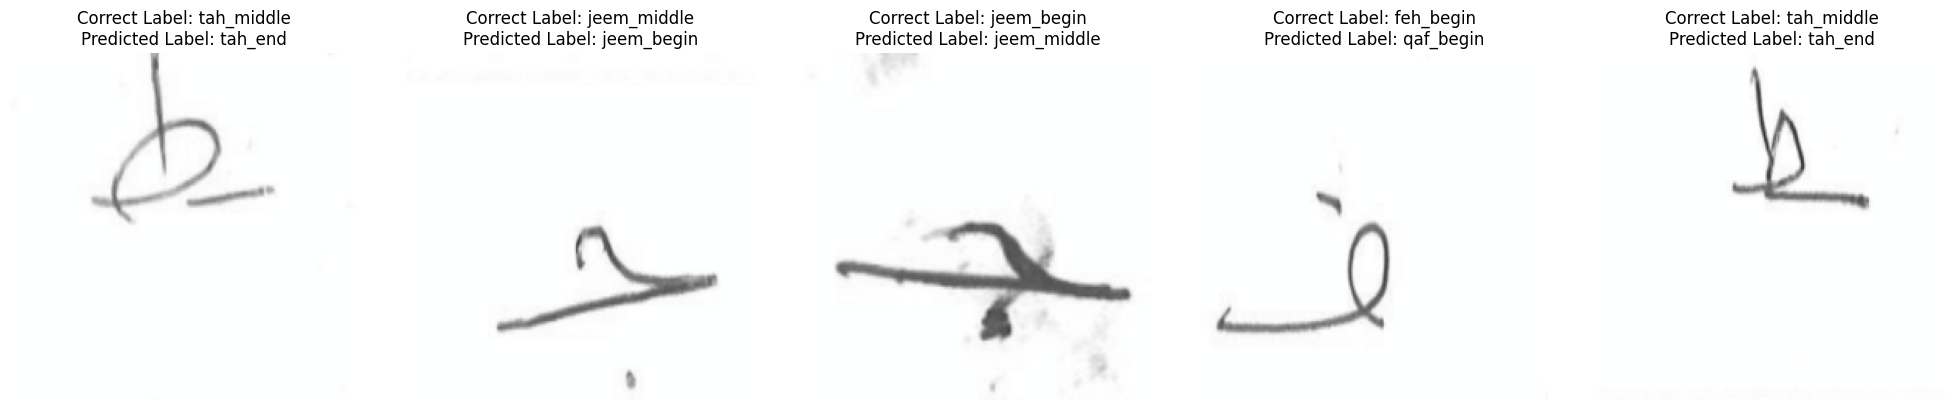

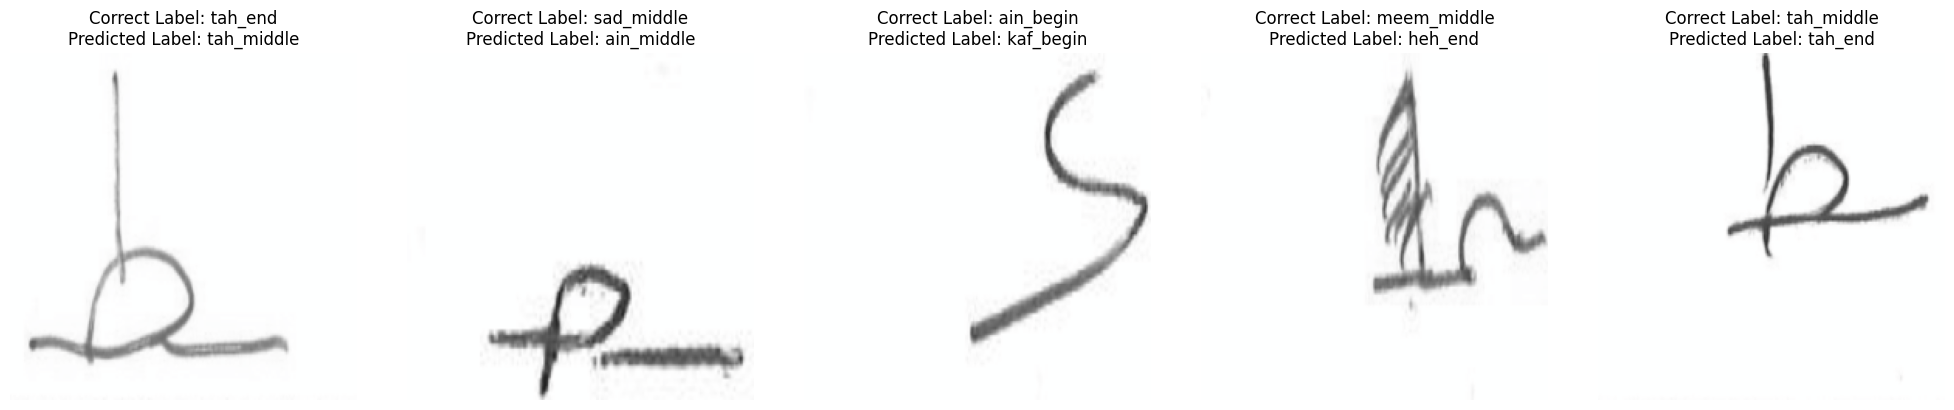

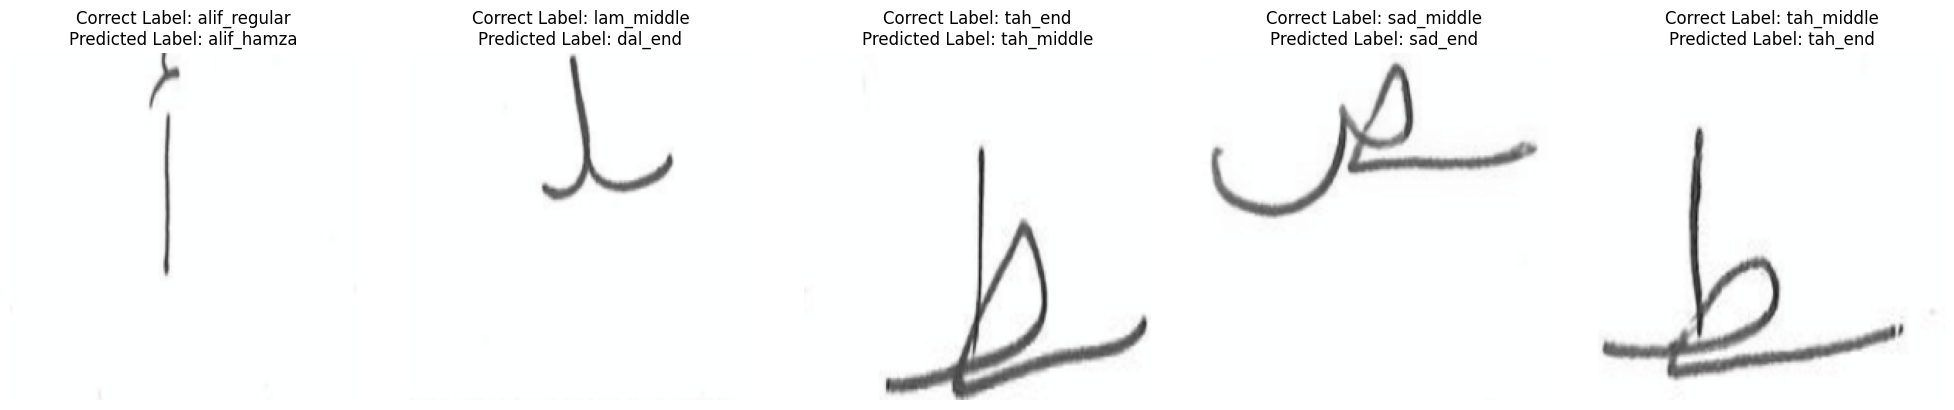

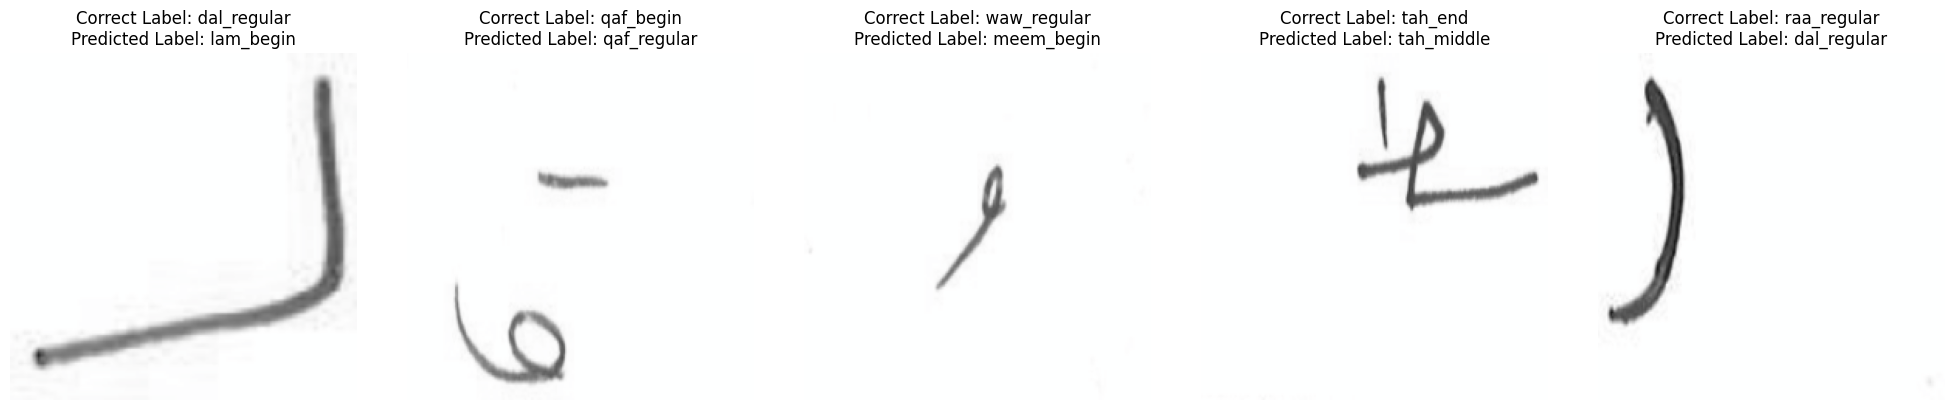

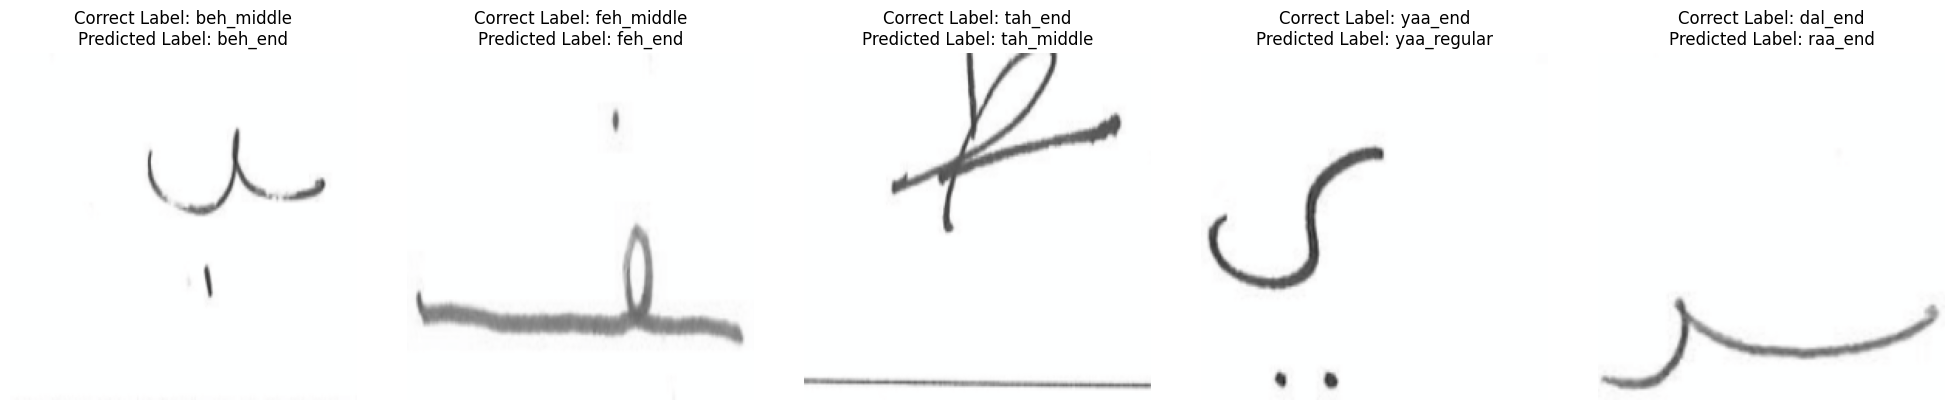

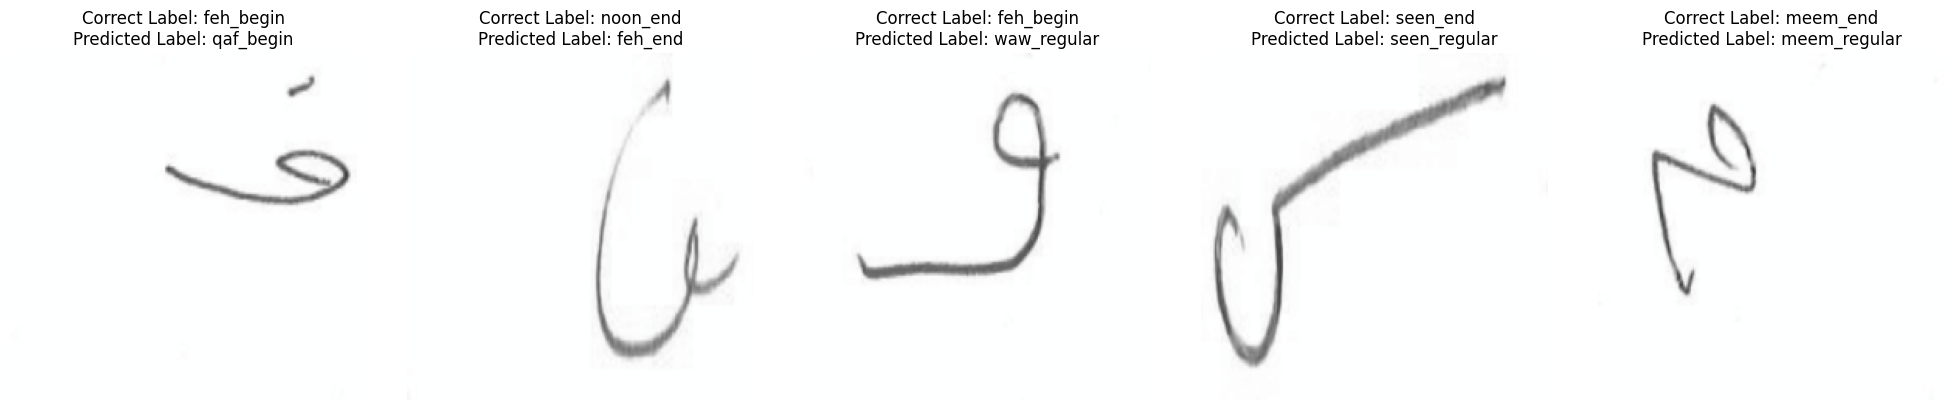

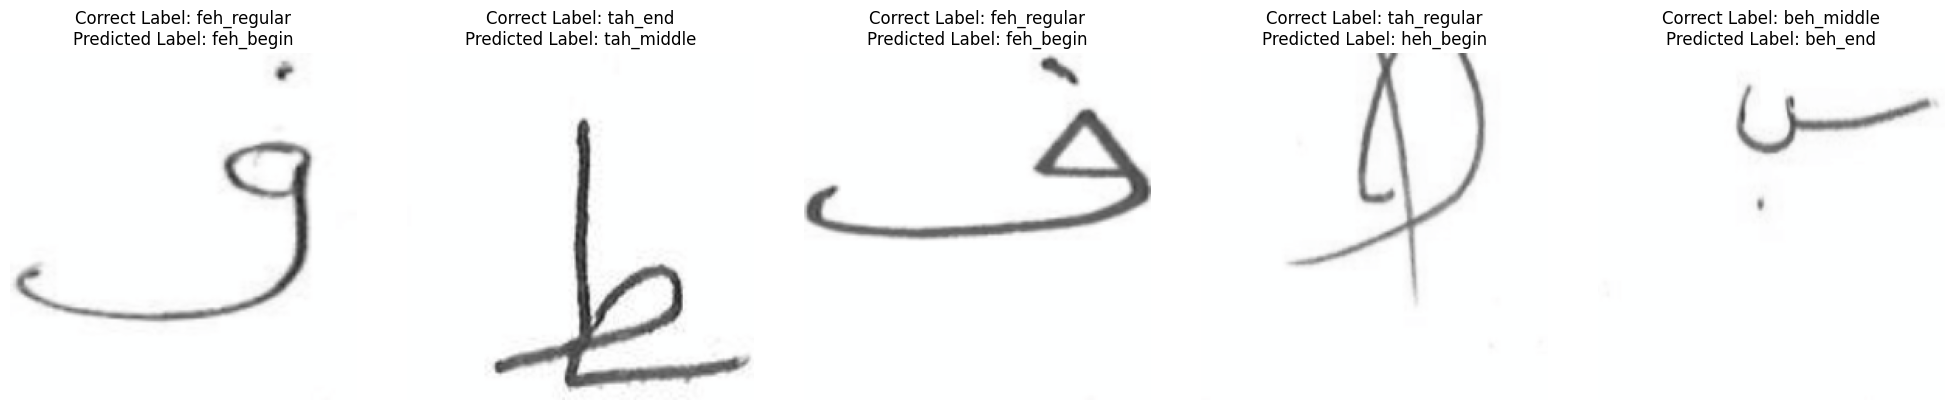

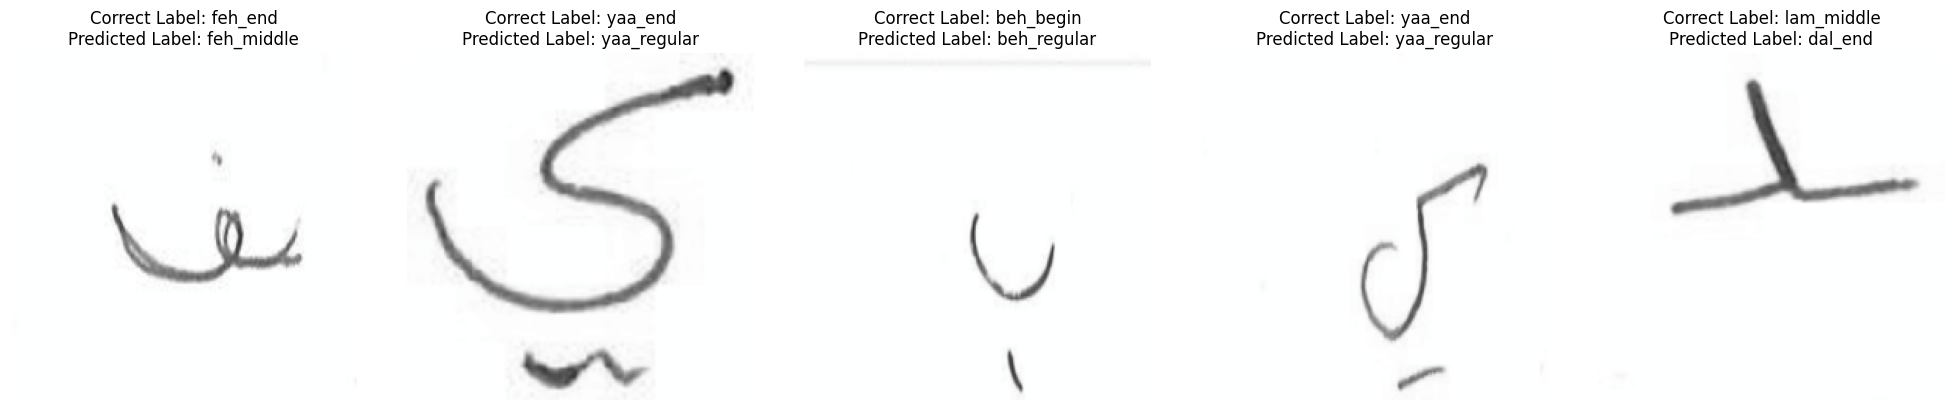

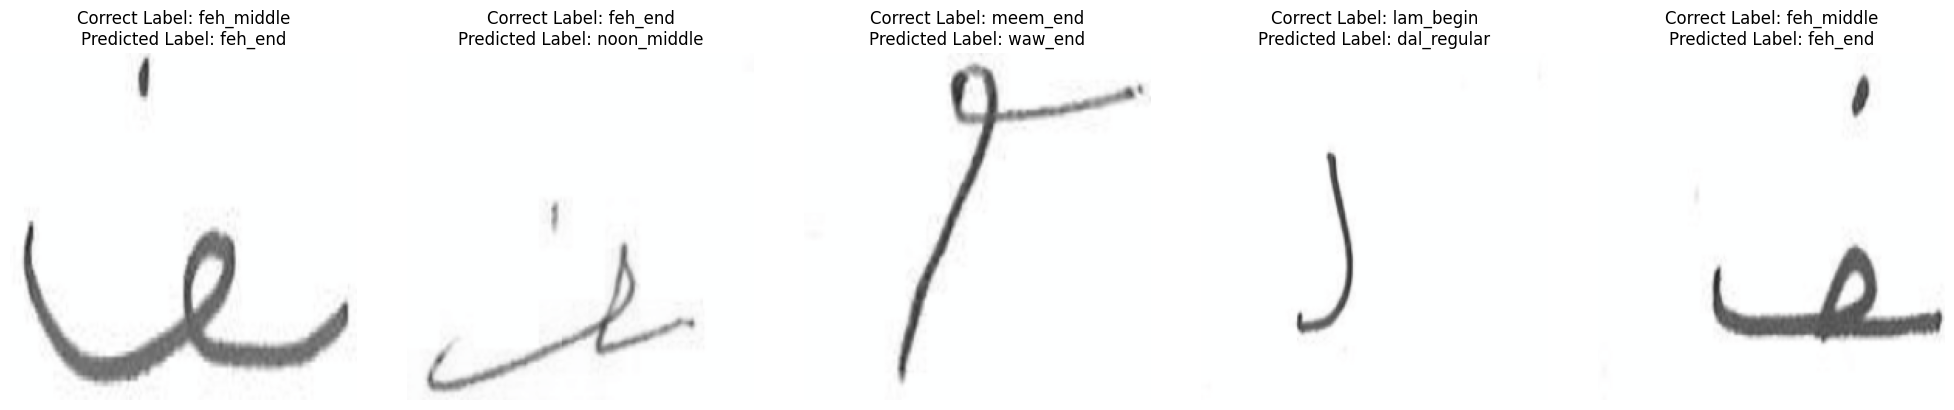

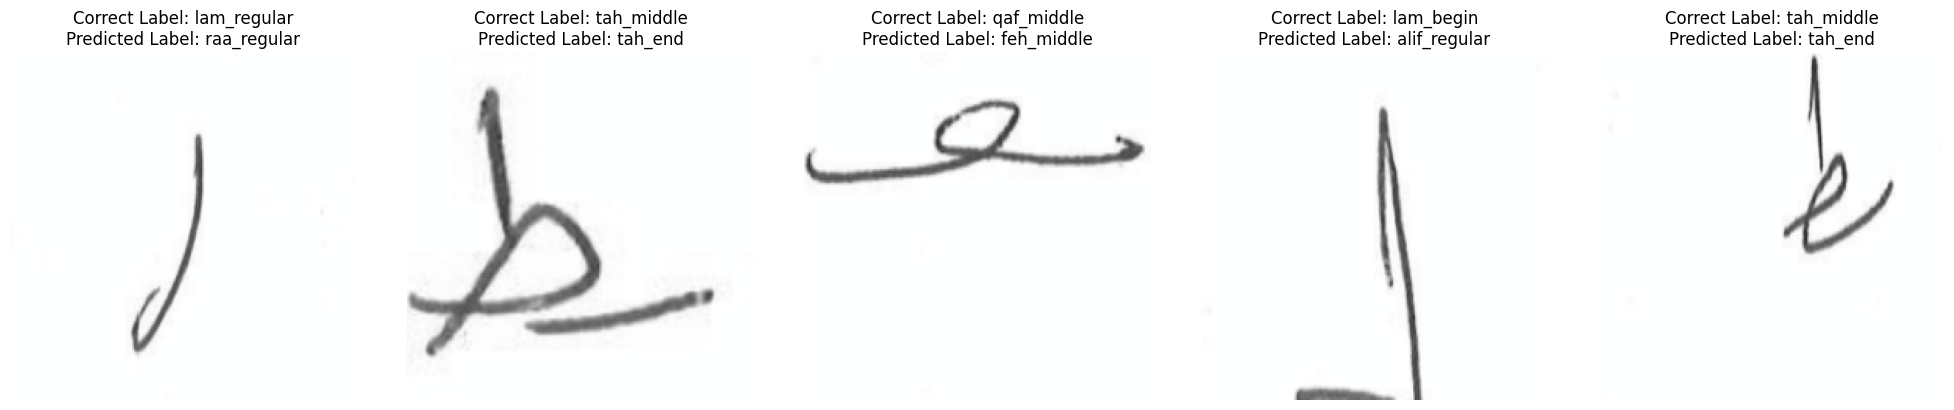

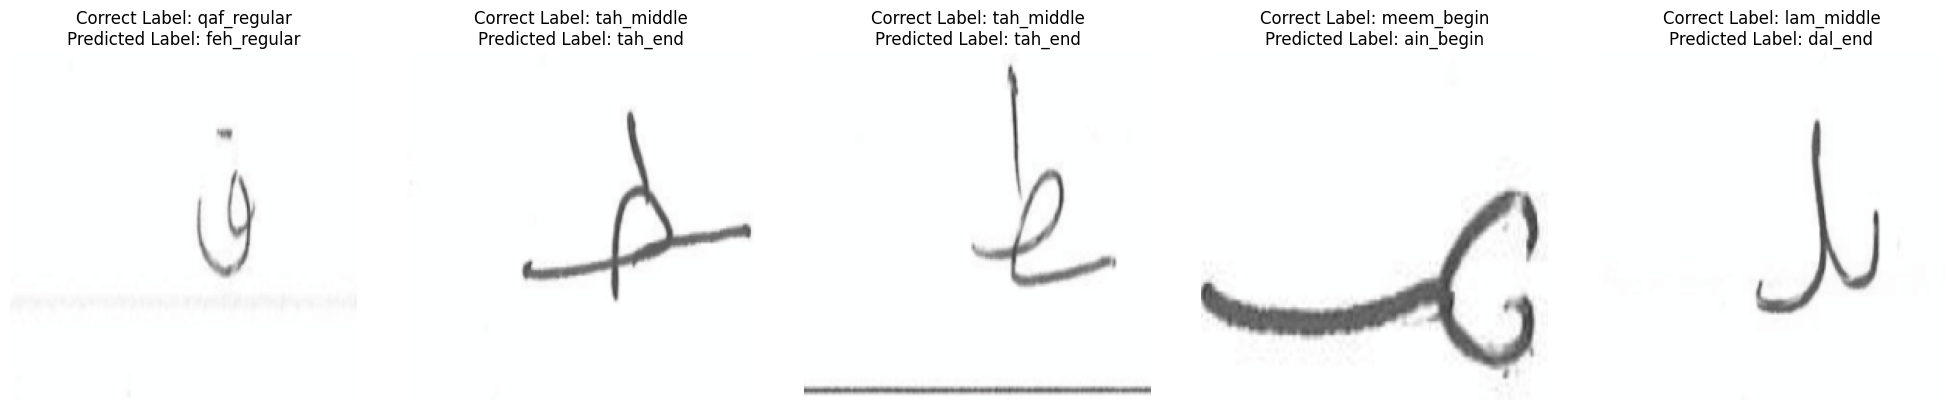

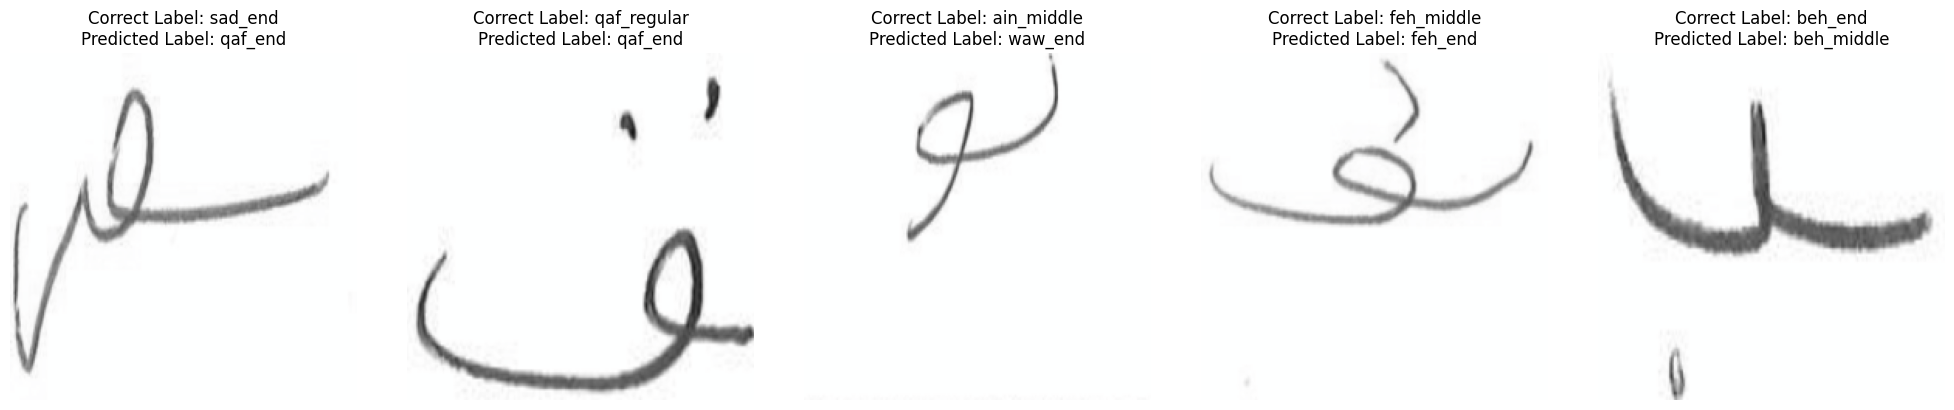

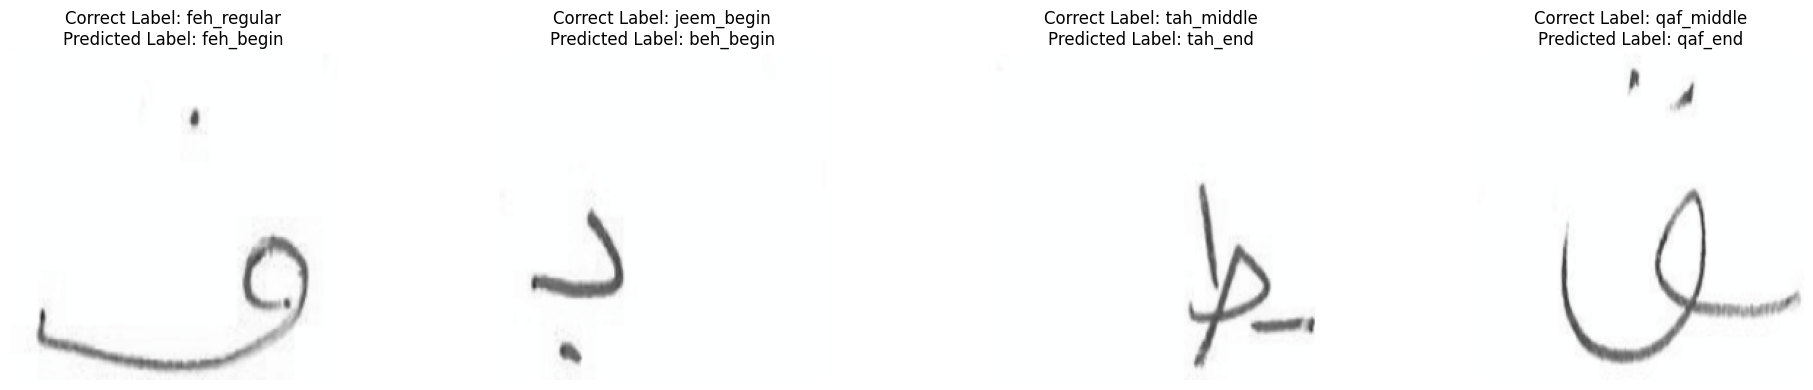

In [120]:
num_images = len(false)  # Total number of false predictions
batch_size = 5  # Number of images per row
num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches needed

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, num_images)
    
    # Create a new figure for each batch
    fig, axes = plt.subplots(1, min(batch_size, end_idx - start_idx), figsize=(20, 4))
    
    for i in range(start_idx, end_idx):
        image, label, predicted = false[i]
        title = f'Correct Label: {labels_dict[str(label.item())]}\nPredicted Label: {labels_dict[str(predicted.item())]}'
        ax = axes[i - start_idx] if batch_size > 1 else axes
        imshow(image, ax=ax, title=title)

    plt.tight_layout()
    plt.show()
